# AIML CA2
## Clustering

Name: Glenn Wu
Adm. No: 2214395
Class: DAAA/FT/2A/01

1. Write the code to solve the clustering task. Use scikit-learn only (do not use
other 3rd party libraries).
2. Write a short report detailing your implementation, your experiments and
analysis in the Jupyter notebook (along with your python code and
comments).
3. Test your clustering with different possible values of k.
4. Determine the best possible value of k. And show how you are able to
determine that this is the best value for k.
5. Use more than just one clustering (k-means) algorithm.
6. Create a set slides with the highlights of your Jupyter notebook. Explain
the unsupervised machine learning process, model building and
evaluation. Write your conclusions.

## Background Research
The goal of this clustering is to identify the group of customers that is the most valuable to the shopping mall so that the
shopping mall can do something to retain them. <br>
Generally, woman tend to spend more than men. [Source](https://finance.yahoo.com/news/why-women-spend-526k-more-150013805.html)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation
from sklearn.mixture import GaussianMixture
from kmodes.kprototypes import KPrototypes 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import ParameterGrid


from scipy.stats import probplot, kstest

sns.set()

In [4]:
df = pd.read_csv("Customer_Dataset.csv").set_index("CustomerID")

In [5]:
eda_df = df.copy()
eda_df.head()

,Gender,Age,Income (k$),How Much They Spend
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [6]:
eda_df.describe()

,Age,Income (k$),How Much They Spend
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [7]:
eda_df.isna().sum()

Gender                 0
Age                    0
Income (k$)            0
How Much They Spend    0
dtype: int64

# Exploratory Data Analysis

We will begin by conducting an exploratory data analysis of the data, to gain a better understanding of the characteristics of the dataset.

The dataset is about Customers of a Mall. There are 200 rows and 5 columns.<br>
**Customer ID**: Unique ID assigned to the customer<br>
**Gender**: Gender of the customer<br>
**Age**: Age of the customer<br>
**Income (k$)**: Annual Income of the customer in thousands of dollars<br>
**How Much They Spend**: Score assigned by the mall based on customer behavior and spending nature<br>

In [8]:
print(eda_df.columns)

numeric_columns = ['Age', 'Income (k$)', 'How Much They Spend']
categorical_columns = ['Gender']

Index(['Gender', 'Age', 'Income (k$)', 'How Much They Spend'], dtype='object')


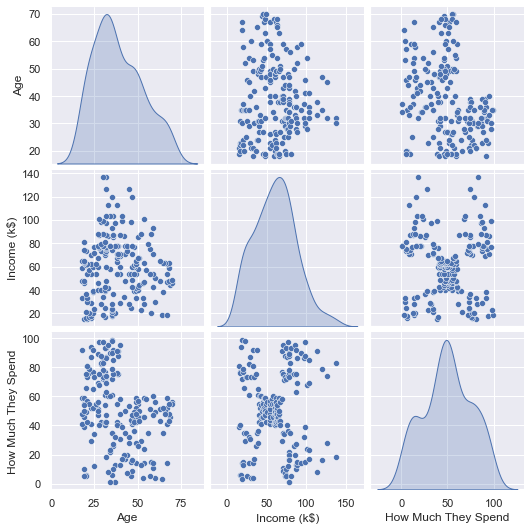

In [9]:
# plt.figure(figsize=(15, 15))

sns.pairplot(eda_df, kind="scatter", diag_kind="kde")

plt.show()

* There seems to be a rigid cut off where customers above their mid 30s stop spending more than 60.

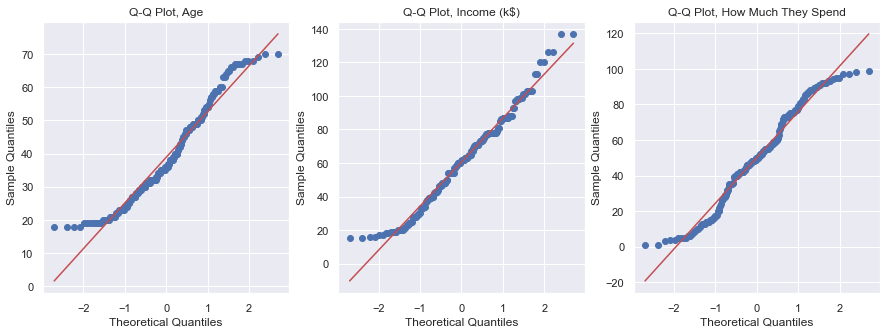

In [10]:
# Q-Q plot
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
for ax, column in zip(axes, numeric_columns):
    probplot(eda_df[column], dist='norm', plot=ax)
    ax.set_title(f'Q-Q Plot, {column}')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')
plt.show()

* None of the numerical features have a gaussian distribution, models like Gaussian Mixture may not be suitable for this task.

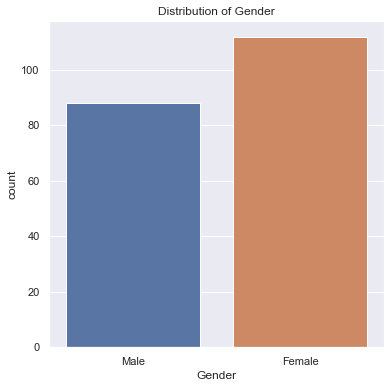

In [11]:
sns.set()

# Distribution of the target variable
plt.figure(figsize=(6, 6))
sns.countplot(x='Gender', data=eda_df)
plt.title('Distribution of Gender')
plt.show()

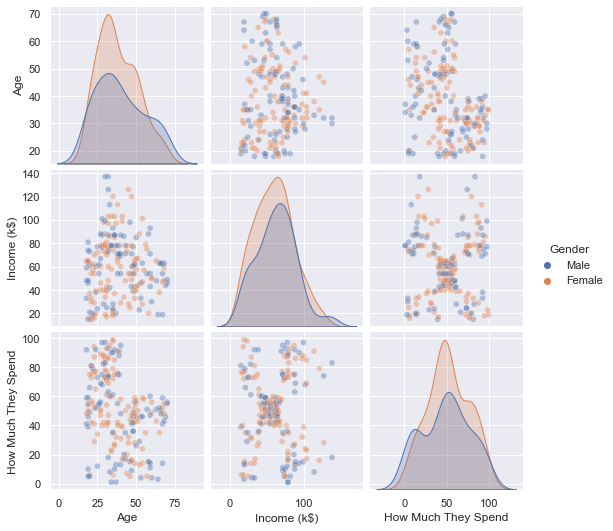

In [12]:
# plt.figure(figsize=(15, 15))

sns.pairplot(eda_df, kind="scatter", diag_kind="kde", hue="Gender", plot_kws=dict(alpha=0.4))

plt.show()

In [13]:
gender_sep_df = pd.DataFrame()
for i in np.unique(eda_df["Gender"]):
    gender_sep_df[i] = round(eda_df[eda_df["Gender"] == i].drop(columns="Gender").mean(), 2)
gender_sep_df["Difference as % of Range"] = abs(gender_sep_df["Male"] - gender_sep_df["Female"]) / (eda_df.describe().loc["max"] - eda_df.describe().loc["min"] ) * 100
gender_sep_df

,Female,Male,Difference as % of Range
Age,38.10,39.81,3.288462
Income (k$),59.25,62.23,2.442623
How Much They Spend,51.53,48.51,3.081633


* Female customers, compared to Male customers, tend to:
    * be younger,
    * earn less, 
    * and spend more 
    
The Female customers' tendancy to spend more may make them more valuable customers, thus I will keep this column.

The mean difference between the different features separated by Gender is roughly 3% of the range for each feature. I will make use of this in when encoding the data.

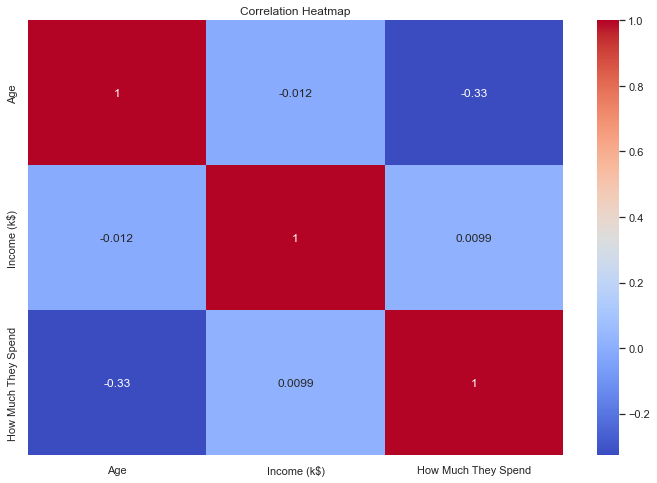

In [14]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(eda_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

**Observations**
* Moderate negatively linear relationship between Age and "How Much They Spend"

In [15]:
standard_scaler = StandardScaler()
one_hot_encoder = OneHotEncoder(sparse=False)

ct = ColumnTransformer(
    transformers=[
        ("standard_scaler", StandardScaler(), numeric_columns),
        ("one_hot_encoder", OneHotEncoder(sparse_output=False), ["Gender"])
    ]
)

transformed_features = ct.fit_transform(df)

std_ct = ColumnTransformer(
    transformers=[
        ("standard_scaler", StandardScaler(), numeric_columns)
    ],
    remainder="passthrough"
)

yj_ct = ColumnTransformer(
    transformers=[
        ("yj", PowerTransformer(method="yeo-johnson"), numeric_columns)
    ],
    remainder="passthrough"
)

eda_std_scaled_features = std_ct.fit_transform(df)
eda_std_scaled_features_df = pd.DataFrame(eda_std_scaled_features, columns=['Age', 'Income (k$)', 'How Much They Spend', 'Gender'])

eda_yj_scaled_features = yj_ct.fit_transform(df)
eda_yj_scaled_features_df = pd.DataFrame(eda_yj_scaled_features, columns=['Age', 'Income (k$)', 'How Much They Spend', 'Gender'])

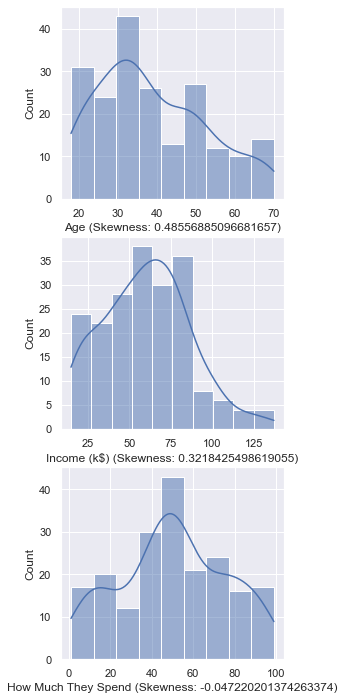

In [16]:
fig, axes = plt.subplots(ncols=1, nrows=len(numeric_columns), figsize=(4, 4*len(numeric_columns)))

for i, col in enumerate(numeric_columns):
    sns.histplot(data=eda_df, x=col, ax=axes[i], kde=True)
    axes[i].set_xlabel(f"{col} (Skewness: {eda_df.skew()[col]})")
    
plt.show()

### Yeo-Johnson Transformation

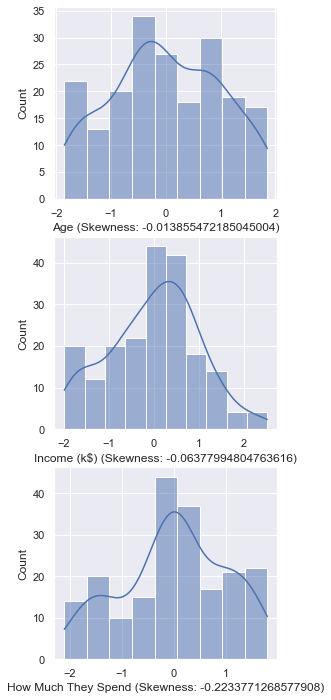

In [17]:
fig, axes = plt.subplots(ncols=1, nrows=len(numeric_columns), figsize=(4, 4*len(numeric_columns)))

for i, col in enumerate(numeric_columns):
    sns.histplot(data=eda_yj_scaled_features_df, x=col, ax=axes[i], kde=True)
    axes[i].set_xlabel(f"{col} (Skewness: {eda_yj_scaled_features_df.skew()[col]})")
    
# plt.title("Yeo-Johnson Transform and Standard Scaling")
    
plt.show()

**Observations** 

* I will use Yeo-Johnson transformation on the Age and Income features since that improved their skewness. I will only perform standardization on the "How Much They Spend" feature since the boxcox transformation hurt its skewness.
* Data with low skew can be beneficial to models like K-Means since the centroids of the clusters are less likely to be heavily influenced by extreme values, resulting in more stable and accurate cluster assignments.

In [18]:
ct = ColumnTransformer(
    transformers=[
#         ("boxcox", PowerTransformer(method="box-cox"), ['Age', 'Income (k$)']),
        ("yj", PowerTransformer(method="yeo-johnson"), ['Age', 'Income (k$)']),
#         ("standard_scaler", StandardScaler(), ['Age', 'Income (k$)', 'How Much They Spend']),
        ("standard_scaler", StandardScaler(), ['How Much They Spend']),
        ("onehot_encode", OneHotEncoder(), ["Gender"])
    ],
    remainder="passthrough"
)

# ct = ColumnTransformer(
#     transformers=[
#         ("standard_scaler", StandardScaler(), ['How Much They Spend', 'Age', 'Income (k$)']),
#         ("onehot_encode", OneHotEncoder(), ["Gender"])
#     ],
#     remainder="passthrough"
# )

transformed_features = ct.fit_transform(df)
# transformed_features = StandardScaler().fit_transform(transformed_features)
transformed_features_df = pd.DataFrame(transformed_features, columns=['Age', 'Income (k$)', 'How Much They Spend', 'Gender_Female', 'Gender_Male'])
# transformed_features_df = transformed_features_df.drop(columns="Gender_Male")
# transformed_features_df = transformed_features_df.drop(columns="Gender_Female")
# transformed_features_df["Gender_Male"] = (transformed_features_df["Gender_Male"] - 0.5) * 0.3

In [19]:
df.head()

,Gender,Age,Income (k$),How Much They Spend
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [20]:
transformed_features_df.head()

,Age,Income (k$),How Much They Spend,Gender_Female,Gender_Male
0,-1.718993,-1.989930,-0.434801,0.0,1.0
1,-1.470002,-1.989930,1.195704,0.0,1.0
2,-1.591912,-1.930366,-1.715913,1.0,0.0
3,-1.240020,-1.930366,1.040418,1.0,0.0
4,-0.461118,-1.872032,-0.395980,1.0,0.0


### t-Distributed Stochastic Neighbour Embedding
Since there are more than 4 features in the data, it is difficult to completely represent in a 2-dimensional format. Thus I will use t-Distributed Stochastic Neighbour Embedding (t-SNE). 

In [21]:
class plot_tsne:
    def __init__(self, data, perplexities, **kwargs):
        tsnes = []
        self.perplexities = perplexities
        for perp in perplexities:
            tsnes.append(pd.DataFrame(TSNE(perplexity=perp, **kwargs).fit_transform(data)))
        self.tsnes = tsnes
    def plot(self, labels, title="", centroids=True,**kwargs):
#         print(labels)
        fig, axes = plt.subplots(**kwargs)
        axes = axes.flatten()
        for i, tsne in enumerate(self.tsnes):
            if labels == []:
                sns.scatterplot(x=tsne.iloc[:, 0], y=tsne.iloc[:, 1], ax=axes[i], palette="tab20")
            else:
                sns.scatterplot(x=tsne.iloc[:, 0], y=tsne.iloc[:, 1], hue=labels, ax=axes[i], palette="tab20")
                if centroids:
                    centroid_clf = NearestCentroid()
                    centroid_clf.fit(np.array(tsne), labels)
                    centroid_pts = centroid_clf.centroids_
#                     print(centroid_clf.centroids_)
                    axes[i].scatter(
                            centroid_pts[:, 0],
                            centroid_pts[:, 1],
                            marker="o",
                            c="white",
                            alpha=0.5,
                            s=200,
                            edgecolor="k",
                        )
                    for k, c in enumerate(centroid_pts):
                        axes[i].scatter(
                            c[0],
                            c[1],
                            marker="$%d$" % k,
                            alpha=1,
                            s=50,
                            edgecolor="k",
                        )
                axes[i].get_legend().remove()
            axes[i].set_title(f"t-SNE (Perplexity: {self.perplexities[i]})")
        if title != "":
            fig.suptitle(title, fontsize=16)
        plt.show()


[Data needs to be standard scaled for t-SNE](https://scikit-learn.org/stable/modules/manifold.html#:~:text=Make%20sure%20the%20same%20scale%20is%20used%20over%20all%20features.%20Because%20manifold%20learning%20methods%20are%20based%20on%20a%20nearest%2Dneighbor%20search%2C%20the%20algorithm%20may%20perform%20poorly%20otherwise.%20See%20StandardScaler%20for%20convenient%20ways%20of%20scaling%20heterogeneous%20data.)

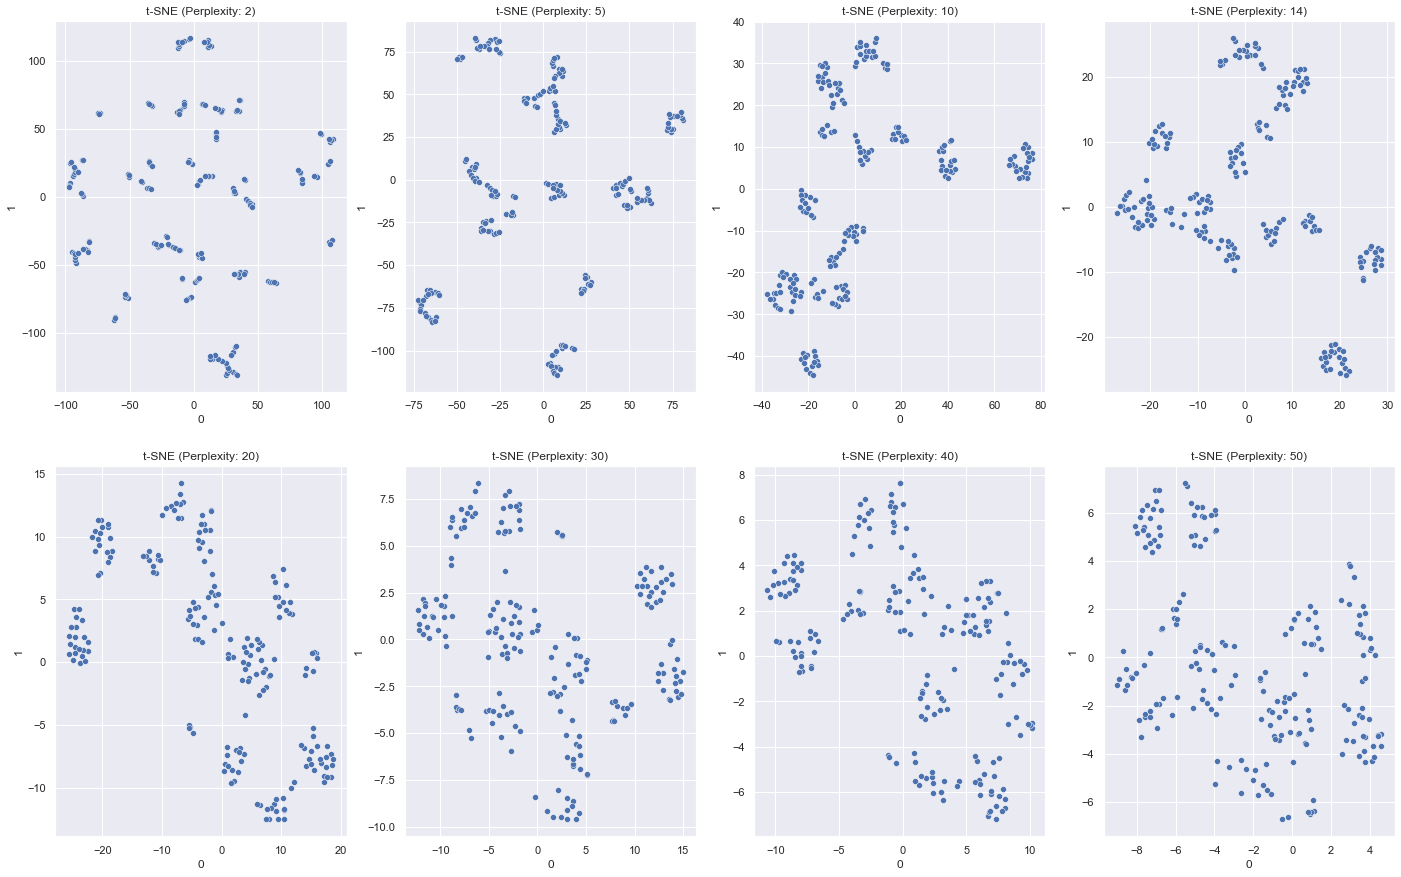

In [114]:
eda_tsneplot = plot_tsne(transformed_features_df, [2, 5, 10, round(np.sqrt(200)), 20, 30, 40, 50], n_iter=5000)
eda_tsneplot.plot([], centroids=False, ncols=4, nrows=2, figsize=(24, 15))

The ```perplexity``` hyperparameter helps to control how many nearest neighbors each point considers. Relationships between neighbouring points (points within a given radius determined by perplexity) are emphasized. It is useful to consider the t-SNE plot at different perplexity values since there is a tradeoff between preserving local and global structures. In this case I will consider perplexities of 20 and 30.

In [31]:
tsneplot = plot_tsne(transformed_features_df, [20, 30], n_iter=5000)

## Metrics
1. **Silhouette Score:**

    The Silhouette Score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). For a sample $i$, the Silhouette Score is calculated as:

    $
    \text{Silhouette}(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
    $

    Where:
    - $a(i)$ is the average distance from the sample $i$ to the other data points in the same cluster.
    - $b(i)$ is the smallest average distance from the sample $i$ to data points in a different cluster, minimized over clusters.
    

2. **Calinski-Harabasz Index (Variance Ratio Criterion):**

    The Calinski-Harabasz Index measures the ratio of between-cluster variance to within-cluster variance. For a given clustering with $K$ clusters, it is calculated as:

    $
    \text{CHI} = \frac{\text{Trace}(B_K)}{\text{Trace}(W_K)} \times \frac{N - K}{K - 1}
    $

    Where:
    - $\text{Trace}(B_K)$ is the trace of the between-cluster scatter matrix. (trace is the sum of elements on the main diagonal)
    - $\text{Trace}(W_K)$ is the trace of the within-cluster scatter matrix.
    - $N$ is the total number of data points.
    - $K$ is the number of clusters.
    

3. **Davies-Bouldin Index:**

    The Davies-Bouldin Index measures the average similarity between each cluster and its most similar cluster. For a given clustering with $K$ clusters, it is calculated as:

    $
    \text{DBI} = \frac{1}{K} \sum_{i=1}^{K} \max_{j \neq i} \left( \frac{S_i + S_j}{d(c_i, c_j)} \right)
    $

    Where:
    - $S_i$ is a measure of the scatter of points within cluster $i$.
    - $d(c_i, c_j)$ is the distance between the centroids of clusters $i$ and $j$.



In [32]:
scores = {
    "wcss": {}, 
    "silhouette": {},
    "calinski_harabasz": {},
    "davies_bouldin": {}
}

n_clusters = 16

def init_scoring(name):
    scores["wcss"][name] = {}
    scores["silhouette"][name] = {}
    scores["calinski_harabasz"][name] = {}
    scores["davies_bouldin"][name] = {}

def set_scores(name, key, X, labels):
    scores["silhouette"][name][key] = silhouette_score(X, labels, metric='euclidean')
    scores["calinski_harabasz"][name][key] = calinski_harabasz_score(X, labels)
    scores["davies_bouldin"][name][key] = davies_bouldin_score(X, labels)

def normalise(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))
    
def eval_plots(name, plot_elbow=True, **kwargs):
    fig, axes = plt.subplots(nrows=1, ncols=(2 if plot_elbow else 1), **kwargs)
    
    # Elbow & Silhouette Plot Visualization
    
    if plot_elbow:
        axes[0].plot(list(scores["wcss"][name].keys()), list(scores["wcss"][name].values()), 'bx-')
        axes[0].set_title('Elbow Plot\n', fontsize = 15)
        axes[0].set_xticks(list(scores["wcss"][name].keys()), labels=[str(x) for x in scores["wcss"][name].keys()])

        axes[1].plot(list(scores["silhouette"][name].keys()), normalise(list(scores["silhouette"][name].values())), 'yx-', label="Silhouette")
        axes[1].plot(list(scores["calinski_harabasz"][name].keys()), normalise(list(scores["calinski_harabasz"][name].values())), 'rx-', label="Calinski-Harabasz")
        axes[1].plot(list(scores["davies_bouldin"][name].keys()), normalise(list(scores["davies_bouldin"][name].values())), 'gx-', label="Davies-Bouldin")
        axes[1].set_title('Evaluation Metrics (Normalised Scale)\n', fontsize = 15)
        axes[1].set_xticks(list(scores["silhouette"][name].keys()), labels=[str(x) for x in scores["silhouette"][name].keys()])
    else:
        axes.plot(list(scores["silhouette"][name].keys()), normalise(list(scores["silhouette"][name].values())), 'yx-', label="Silhouette")
        axes.plot(list(scores["calinski_harabasz"][name].keys()), normalise(list(scores["calinski_harabasz"][name].values())), 'rx-', label="Calinski-Harabasz")
        axes.plot(list(scores["davies_bouldin"][name].keys()), normalise(list(scores["davies_bouldin"][name].values())), 'gx-', label="Davies-Bouldin")
        axes.set_title('Evaluation Metrics (Normalised Scale)\n', fontsize = 15)
        axes.set_xticks(list(scores["silhouette"][name].keys()), labels=[str(x) for x in scores["silhouette"][name].keys()])
    
    plt.legend()
    return fig, axes
#     plt.show()

def optimal_n_cluster(name, show=True, optimal_what="Number of Clusters"):
    opt_silhouette = list(scores["silhouette"][name].keys())[np.argmax(list(scores["silhouette"][name].values()))]
#     print(list(scores["calinski_harabasz"][name].values()))
    opt_calinski_harabasz = list(scores["calinski_harabasz"][name].keys())[np.argmax(list(scores["calinski_harabasz"][name].values()))]
    opt_davies_bouldin = list(scores["davies_bouldin"][name].keys())[np.argmin(list(scores["davies_bouldin"][name].values()))]
    if show:
        print(f"Optimal {optimal_what} for {name} (Silhouette): {opt_silhouette}")
        print(f"Optimal {optimal_what} for {name} (Calinski-Harabasz): {opt_calinski_harabasz}")
        print(f"Optimal {optimal_what} for {name} (Davies-Bouldin): {opt_davies_bouldin}")
    else: 
        return opt_silhouette, opt_calinski_harabasz, opt_davies_bouldin

### K-Means Clustering

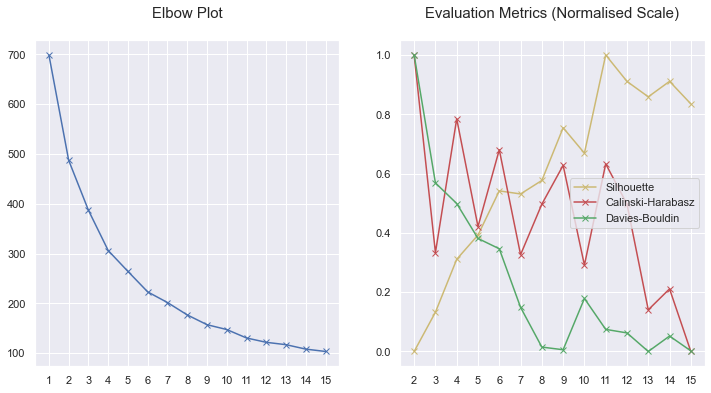

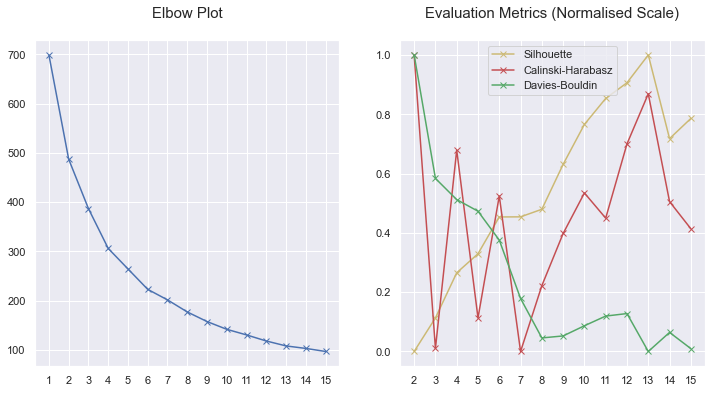

Optimal Number of Clusters for k-means-random (Silhouette): 11
Optimal Number of Clusters for k-means-random (Calinski-Harabasz): 2
Optimal Number of Clusters for k-means-random (Davies-Bouldin): 13
Optimal Number of Clusters for k-means++ (Silhouette): 13
Optimal Number of Clusters for k-means++ (Calinski-Harabasz): 2
Optimal Number of Clusters for k-means++ (Davies-Bouldin): 13


In [33]:
# plt.figure(figsize=(12,12))

axes=[]

init_scoring("k-means-random")

for k in range(1,n_clusters):
    model = KMeans(n_clusters=k, random_state=23, init="random")
    model.fit(transformed_features_df) #index [0] for column 'Age'
    scores["wcss"]["k-means-random"][k] = model.inertia_
    if k >= 2:
        labels = model.labels_
        set_scores("k-means-random", k, transformed_features, labels)
    
_, axes_temp = eval_plots("k-means-random", figsize=(12,6))
axes.append(axes_temp)

init_scoring("k-means++")

for k in range(1,n_clusters):
    model = KMeans(n_clusters=k, random_state=23, init="k-means++")
    model.fit(transformed_features_df) #index [0] for column 'Age'
    scores["wcss"]["k-means++"][k] = model.inertia_
    if k >= 2:
        labels = model.labels_
        set_scores("k-means++", k, transformed_features, labels)

_, axes_temp = eval_plots("k-means++", figsize=(12,6))
axes.append(axes_temp)

plt.show()

optimal_n_cluster("k-means-random")
optimal_n_cluster("k-means++")

**Observations**
* K-Means using random initialisation and k-means++ initialisation result in similar but not identical results. Much of the result is determined by their random state as well.
* Optimal number of clusters based on the elbow plot is unclear for both K-Means methods but could be either 12 or 14 but it is not very obvious.
* For k-means++ initialisation, based on Silhouette score and Calinski-Harabasz index, 12 and 14 seems to perform nearly equally well but 14 clusters performs slightly better based on the Davies-Bouldin index.

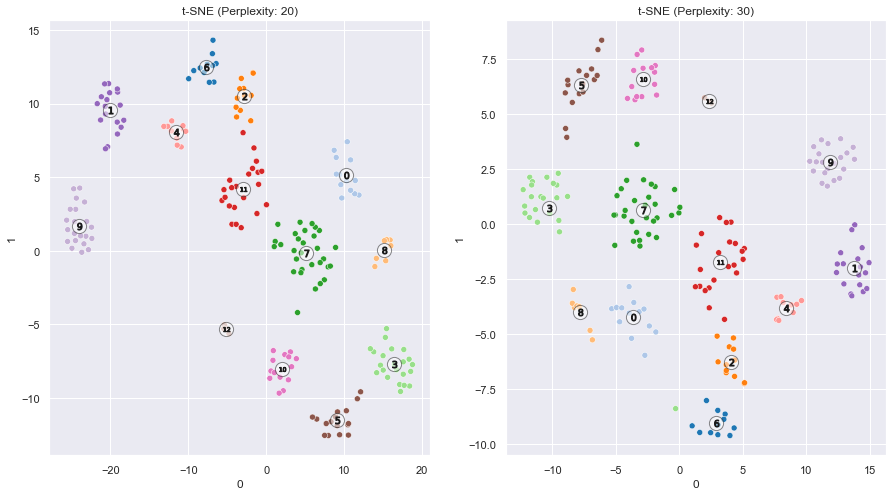

In [34]:
model = KMeans(n_clusters=13, random_state=23, init="k-means++")
model.fit(transformed_features_df)
labels = model.labels_
tsneplot.plot([str(x) for x in labels], ncols=2, nrows=1, figsize=(15, 8))
# tsneplot.plot([str(x) for x in labels], title="K-Means, 6 Clusters", ncols=2, nrows=1, figsize=(15, 8))

# model = KMeans(n_clusters=13, random_state=23, init="k-means++")
# model.fit(transformed_features_df)
# labels = model.labels_
# tsneplot.plot([str(x) for x in labels], title="K-Means, 13 Clusters", ncols=2, nrows=1, figsize=(15, 8))

In [35]:
# model = KMeans(n_clusters=12, random_state=23, init="k-means++")
# model.fit(eda_tsneplot.tsnes[2])
# labels = model.labels_
# eda_tsneplot.plot([str(x) for x in labels], ncols=2, nrows=4, figsize=(15, 24))
# silhouette_score(eda_tsneplot.tsnes[2], labels, metric='euclidean')

**Observations**
* 13 clusters seems to perform slightly better, splitting up the cluster at (-50, 0) in the Perplexity: 20 t-SNE plot.

### Agglomerative Clustering

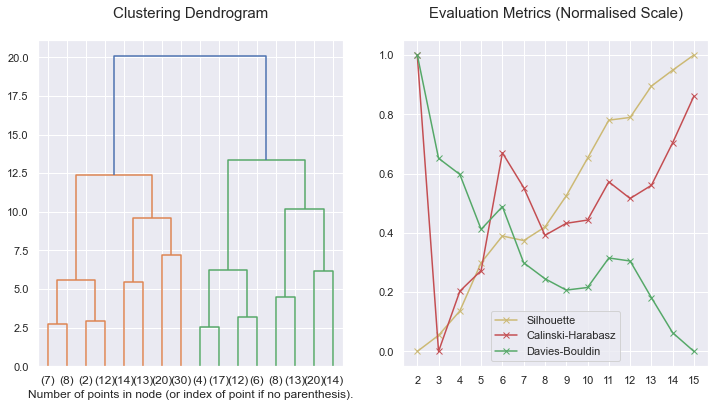

Optimal Number of Clusters for agglomerative (Silhouette): 15
Optimal Number of Clusters for agglomerative (Calinski-Harabasz): 2
Optimal Number of Clusters for agglomerative (Davies-Bouldin): 15


In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

init_scoring("agglomerative")

for k in range(2,n_clusters):
    model = AgglomerativeClustering(n_clusters=k)
    model.fit_predict(transformed_features_df) #index [0] for column 'Age'
    labels = model.labels_
    set_scores("agglomerative", k, transformed_features, labels)

axes[1].plot(list(scores["silhouette"]["agglomerative"].keys()), normalise(list(scores["silhouette"]["agglomerative"].values())), 'yx-', label="Silhouette")
axes[1].plot(list(scores["calinski_harabasz"]["agglomerative"].keys()), normalise(list(scores["calinski_harabasz"]["agglomerative"].values())), 'rx-', label="Calinski-Harabasz")
axes[1].plot(list(scores["davies_bouldin"]["agglomerative"].keys()), normalise(list(scores["davies_bouldin"]["agglomerative"].values())), 'gx-', label="Davies-Bouldin")
axes[1].set_title('Evaluation Metrics (Normalised Scale)\n', fontsize = 15)
axes[1].set_xticks(list(scores["silhouette"]["agglomerative"].keys()), labels=[str(x) for x in scores["silhouette"]["agglomerative"].keys()])

from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(transformed_features)
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3, ax=axes[0])
axes[0].set_title("Clustering Dendrogram\n", fontdict={'fontsize': 15})
axes[0].set_xlabel("Number of points in node (or index of point if no parenthesis).")

plt.legend()
plt.show()

optimal_n_cluster("agglomerative")

**Observations**

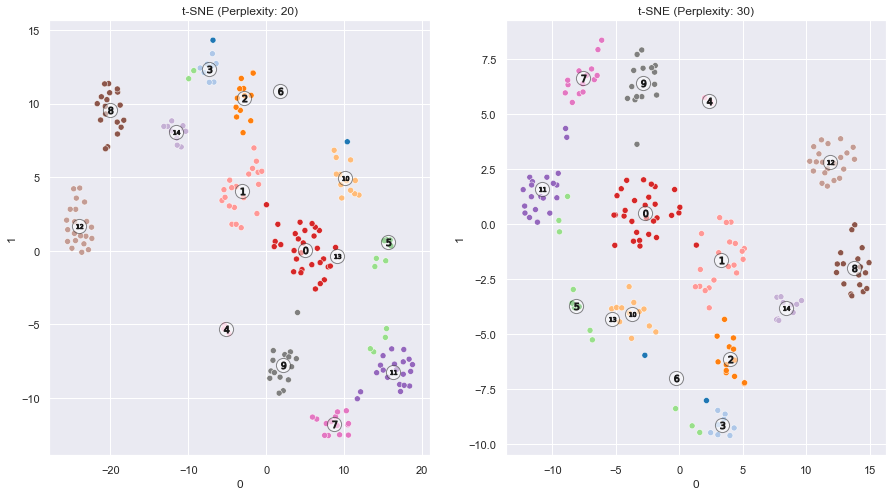

In [37]:
model = AgglomerativeClustering(n_clusters=15)
model.fit_predict(transformed_features_df) #index [0] for column 'Age'
labels = model.labels_
tsneplot.plot([str(x) for x in labels], ncols=2, nrows=1, figsize=(15, 8))

### Spectral Clustering

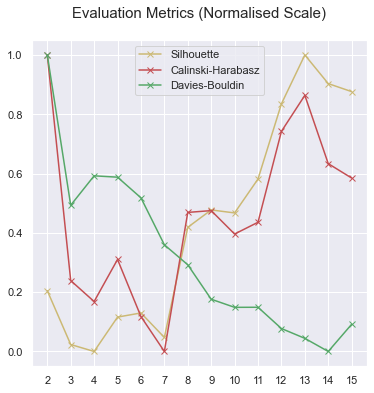

Optimal Number of Clusters for spectral (Silhouette): 13
Optimal Number of Clusters for spectral (Calinski-Harabasz): 2
Optimal Number of Clusters for spectral (Davies-Bouldin): 14


In [38]:
from sklearn.metrics import pairwise_distances

# #this goofy ahhhh don't work
# def compute_wcss(similarity_matrix, labels):
#     distances = pairwise_distances(similarity_matrix, metric='euclidean')
#     wcss = sum(np.min(distances[:, labels == i], axis=1) for i in range(labels.max() + 1))
#     print(wcss)
#     return wcss

# plt.figure(figsize=(12,12))

init_scoring("spectral")

for k in range(2,n_clusters):
    model = SpectralClustering(n_clusters=k, random_state=23)
    model.fit_predict(transformed_features_df) #index [0] for column 'Age'
    labels = model.labels_
#     scores["wcss"]["spectral"][k] = compute_wcss(model.affinity_matrix_, label)
    set_scores("spectral", k, transformed_features, labels)

fig, axes = eval_plots("spectral", plot_elbow=False, figsize=(6,6))

plt.show()

optimal_n_cluster("spectral")

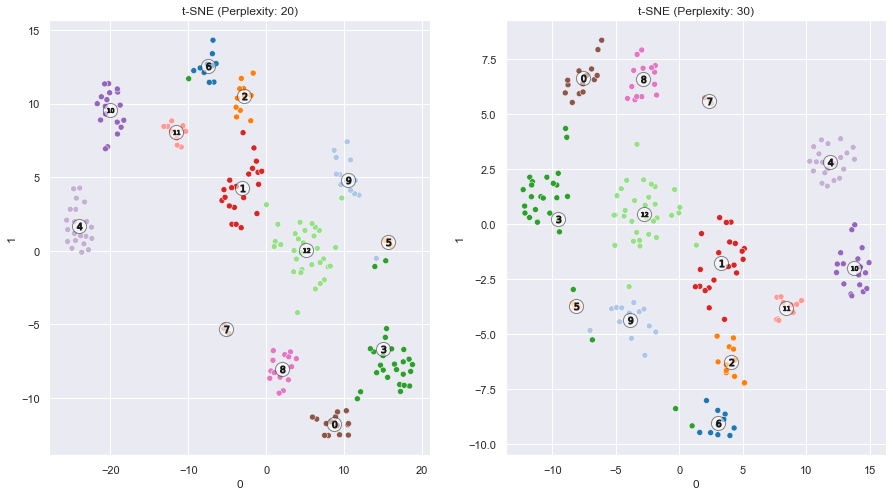

In [39]:
model = SpectralClustering(n_clusters=13, random_state=23)
model.fit_predict(transformed_features_df) #index [0] for column 'Age'
labels = model.labels_
tsneplot.plot([str(x) for x in labels], ncols=2, nrows=1, figsize=(15, 8))

### DBSCAN

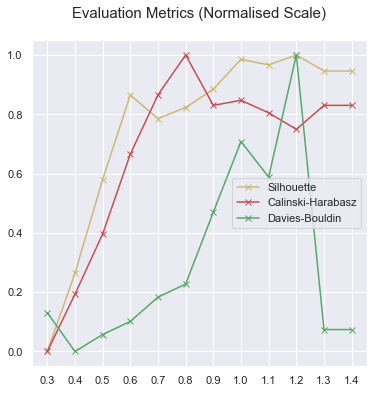

Optimal EP value for dbscan (Silhouette): 1.2
Optimal EP value for dbscan (Calinski-Harabasz): 0.8
Optimal EP value for dbscan (Davies-Bouldin): 0.4


In [40]:
init_scoring("dbscan")

for k in np.arange(0.1, 2, 0.1):
    k = round(k, 3)
    model = DBSCAN(eps=k)
    model.fit_predict(transformed_features_df) #index [0] for column 'Age'
    labels = model.labels_
    if len(set(labels)) > 1:
        set_scores("dbscan", k, transformed_features, labels)
#         print(labels)

fig, axes = eval_plots("dbscan", plot_elbow=False, figsize=(6,6))

plt.show()

optimal_n_cluster("dbscan", optimal_what="EP value")

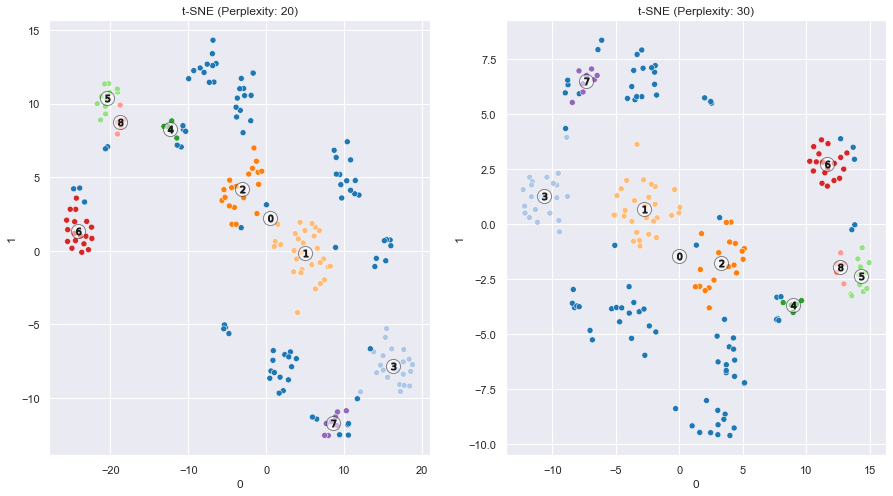

In [41]:
model = DBSCAN(eps=0.6)
model.fit_predict(transformed_features_df) #index [0] for column 'Age'
labels = model.labels_
tsneplot.plot([str(x) for x in labels], ncols=2, nrows=1, figsize=(15, 8))

### Affinity Propagation

Number of Clusters based on Affinity Propagation: 17


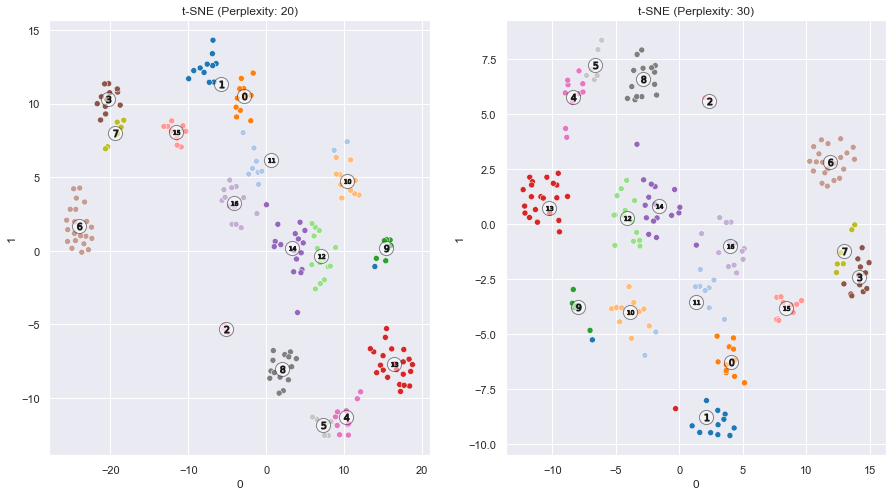

In [42]:
init_scoring("affinity")

affinity_propagation = AffinityPropagation(random_state=42)
labels = affinity_propagation.fit_predict(transformed_features_df)

affinity_n_clusters = len(set(labels))

scores["silhouette"]["affinity"] = silhouette_score(transformed_features, labels, metric='euclidean')
scores["calinski_harabasz"]["affinity"] = calinski_harabasz_score(transformed_features, labels)
scores["davies_bouldin"]["affinity"] = davies_bouldin_score(transformed_features, labels)

# scores["silhouette"]["affinity"][affinity_n_clusters] = silhouette_score(transformed_features, labels, metric='euclidean')
# scores["calinski_harabasz"]["affinity"][affinity_n_clusters] = calinski_harabasz_score(transformed_features, labels)
# scores["davies_bouldin"]["affinity"][affinity_n_clusters] = davies_bouldin_score(transformed_features, labels)

print(f"Number of Clusters based on Affinity Propagation: {affinity_n_clusters}")

tsneplot.plot([str(x) for x in labels], ncols=2, nrows=1, figsize=(15, 8))

<!-- ### K-Prototypes -->

### K-Prototypes

In [43]:
ct = ColumnTransformer(
    transformers=[
#         ("boxcox", PowerTransformer(method="box-cox"), ['Age', 'Income (k$)']),
        ("yj", PowerTransformer(method="yeo-johnson"), ['Age', 'Income (k$)']),
        ("standard_scaler", StandardScaler(), ['How Much They Spend'])
    ],
    remainder="passthrough"
)

transformed_no_ohe_features = ct.fit_transform(df)
transformed_no_ohe_features_df = pd.DataFrame(transformed_no_ohe_features, columns=['Age', 'Income (k$)', 'How Much They Spend', 'Gender'])

In [44]:
transformed_no_ohe_features_df.head()

,Age,Income (k$),How Much They Spend,Gender
0,-1.718993,-1.98993,-0.434801,Male
1,-1.470002,-1.98993,1.195704,Male
2,-1.591912,-1.930366,-1.715913,Female
3,-1.24002,-1.930366,1.040418,Female
4,-0.461118,-1.872032,-0.39598,Female


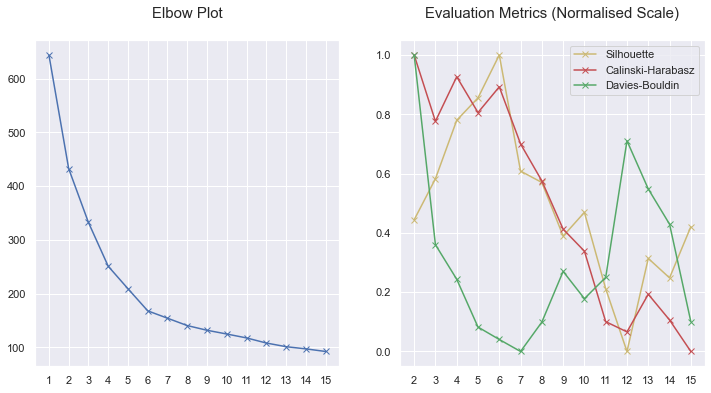

Optimal Number of Clusters for k-prototypes (Silhouette): 6
Optimal Number of Clusters for k-prototypes (Calinski-Harabasz): 2
Optimal Number of Clusters for k-prototypes (Davies-Bouldin): 7


In [45]:
init_scoring("k-prototypes")

for k in range(1, n_clusters):
    model = KPrototypes(n_clusters=k, random_state=23, n_jobs=-1)
    model.fit_predict(transformed_no_ohe_features_df, categorical=[3]) #index [0] for column 'Age'
    scores["wcss"]["k-prototypes"][k] = model.cost_
    if k >= 2:
        labels = model.labels_
        set_scores("k-prototypes", k, transformed_features, labels)

fig, axes = eval_plots("k-prototypes", figsize=(12,6))

plt.show()

optimal_n_cluster("k-prototypes")

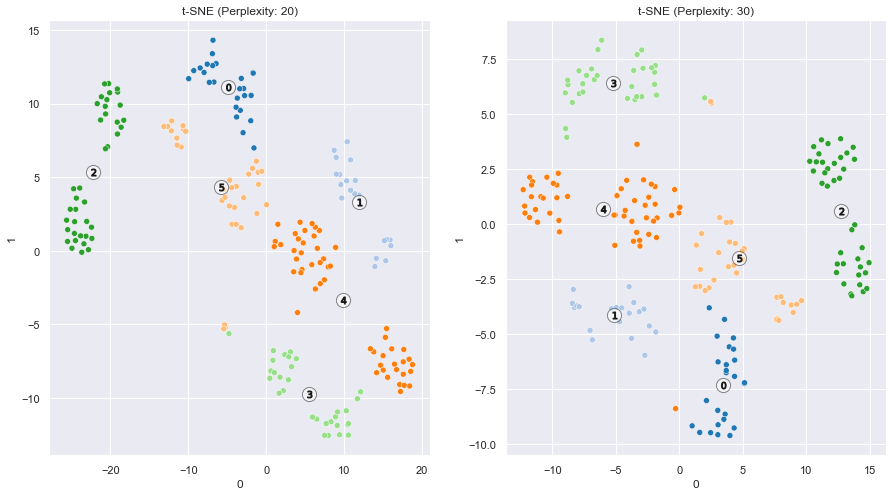

In [46]:
model = KPrototypes(n_clusters=6, random_state=23, n_jobs=-1)
model.fit_predict(transformed_no_ohe_features_df, categorical=[3])
labels = model.labels_
tsneplot.plot([str(x) for x in labels], ncols=2, nrows=1, figsize=(15, 8))

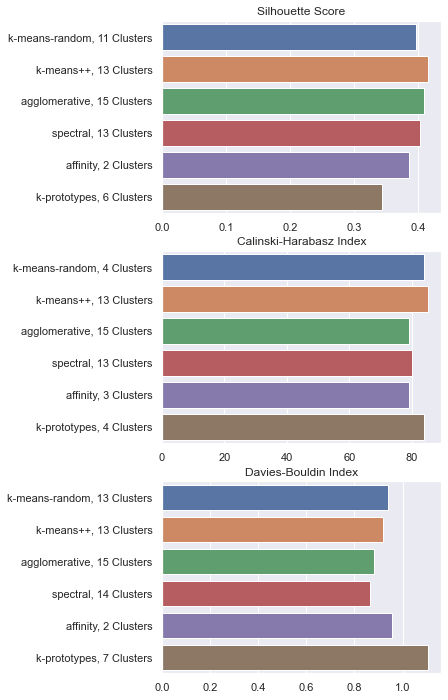

In [222]:
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(5, 12))

silhouette_scores_df = pd.DataFrame(scores['silhouette'])
silhouette_scores_df = silhouette_scores_df.drop("dbscan", axis=1).dropna()
corresponding_n_clusters = [silhouette_scores_df.index[np.argmax(silhouette_scores_df[column])] for column in silhouette_scores_df.columns]
sns.barplot(x=np.max(silhouette_scores_df), y=[f"{x}, {int(n)} Clusters" for x, n in zip(np.max(silhouette_scores_df).index, corresponding_n_clusters)], ax=axes[0])
axes[0].set_title("Silhouette Score")


ch_scores_df = pd.DataFrame(scores['calinski_harabasz'])
ch_scores_df = ch_scores_df.drop("dbscan", axis=1).dropna()
ch_scores_df = ch_scores_df.drop(2)
corresponding_n_clusters = [ch_scores_df.index[np.argmax(ch_scores_df[column])] for column in ch_scores_df.columns]
sns.barplot(x=np.max(ch_scores_df), y=[f"{x}, {int(n)} Clusters" for x, n in zip(np.max(ch_scores_df).index, corresponding_n_clusters)], ax=axes[1])
axes[1].set_title("Calinski-Harabasz Index")


db_scores_df = pd.DataFrame(scores['davies_bouldin'])
db_scores_df = db_scores_df.drop("dbscan", axis=1).dropna()
corresponding_n_clusters = [db_scores_df.index[np.argmin(db_scores_df[column])] for column in db_scores_df.columns]
sns.barplot(x=np.min(db_scores_df), y=[f"{x}, {int(n)} Clusters" for x, n in zip(np.min(db_scores_df).index, corresponding_n_clusters)], ax=axes[2])
axes[2].set_title("Davies-Bouldin Index")


plt.show()

**Observations**
* K-means with k-means++ initialisation seems to perform the best for all metrics at 13 clusters followed by Agglomerative Clustering and K-Prototypes.

## Dimensionality Reduction using Principal Component Analysis
Based on the scoring of the clusters, the optimal number of clusters for all of the models are greater than 10 which makes cluster interpretation more difficult. To counter this, I will try Principal Component Analysis for dimensional reduction by discarding some principal components.

In [22]:
# pre_pca_df = transformed_no_ohe_features_df.loc[:, transformed_no_ohe_features_df.columns != 'Gender']
pre_pca_df = transformed_features_df
pre_pca_df.head()

,Age,Income (k$),How Much They Spend,Gender_Female,Gender_Male
0,-1.718993,-1.989930,-0.434801,0.0,1.0
1,-1.470002,-1.989930,1.195704,0.0,1.0
2,-1.591912,-1.930366,-1.715913,1.0,0.0
3,-1.240020,-1.930366,1.040418,1.0,0.0
4,-0.461118,-1.872032,-0.395980,1.0,0.0


In [23]:
# implementing PCA using sklearn

from sklearn.decomposition import PCA

pca = PCA(n_components=5).fit(pre_pca_df) # equivalent to step 1, 2, 3
#Note that pca.transform() returns scores based on centred data

# choosing PCs decide yourself

pca_samples = pca.transform(pre_pca_df) # step 5, calculating PC based on covariance

In [24]:
def return_pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['PC {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    #PCA eigenvalues
    ev = pca.explained_variance_.reshape(len(pca.components_), 1)
    eigenvalues = pd.DataFrame(np.round(ev, 4), columns = ['Eigenvalue']) 
    eigenvalues.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([eigenvalues, variance_ratios, components], axis = 1)

In [25]:
pca_results = return_pca_results(pre_pca_df, pca)
pca_results["Cumulative Explained Variance"] = np.cumsum(pca_results["Explained Variance"])
pca_results

,Eigenvalue,Explained Variance,Age,Income (k$),How Much They Spend,Gender_Female,Gender_Male,Cumulative Explained Variance
PC 1,1.3305,0.3790,-0.7063,-0.1000,0.6983,0.0415,-0.0415,0.3790
PC 2,1.0101,0.2878,0.0189,0.9841,0.1653,-0.0443,0.0443,0.6668
PC 3,0.6810,0.1940,-0.7073,0.1238,-0.6901,-0.0636,0.0636,0.8608
PC 4,0.4888,0.1392,0.0211,-0.0793,0.0934,-0.7016,0.7016,1.0000
PC 5,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.7071,-0.7071,1.0000


**Observation**
* Only PC 5 explains less than 10% of total variance (Kaiser's Rule)
* To obtain more than 80% cumulative explained variance, we have to select 3 PCs
* The main weights of PC4 and PC5 and on Gender_Female and Gender_Male.

**Conclusion**
* One of the features from the transformed data is completely redundant, either Gender_Male or Gender_Female, since One-Hot encoding makes creates a column for each unique value in the feature. So minimally we should expect that we can discard the last Principal Component.
* Using only Prinicipal Components that have a Cumulative Explained Variance of 80%, we can also discard the 4th PC as well.
* Thus, I will use PC 1, 2, and 3.

In [26]:
pca_scores = np.dot(transformed_features_df, pca.components_.T)
pca_scores = pd.DataFrame(pca_scores, columns = [f"PC{i+1}" for i in range(5)])
pca_scores = pca_scores.drop(columns=["PC4", "PC5"])
# pca_scores = pca_scores.drop(columns=["PC5"])
pca_scores

,PC1,PC2,PC3
0,1.068040,-2.018293,1.333180
1,2.030809,-1.744062,0.031791
2,0.160628,-2.257663,2.007682
3,1.836918,-1.795387,-0.143466
4,0.277844,-1.960692,0.304132
...,...,...,...
195,0.714015,2.133445,-0.489487
196,-1.178524,1.991459,0.405449
197,0.649132,2.357507,-0.035398
198,-0.900372,2.306381,1.503740


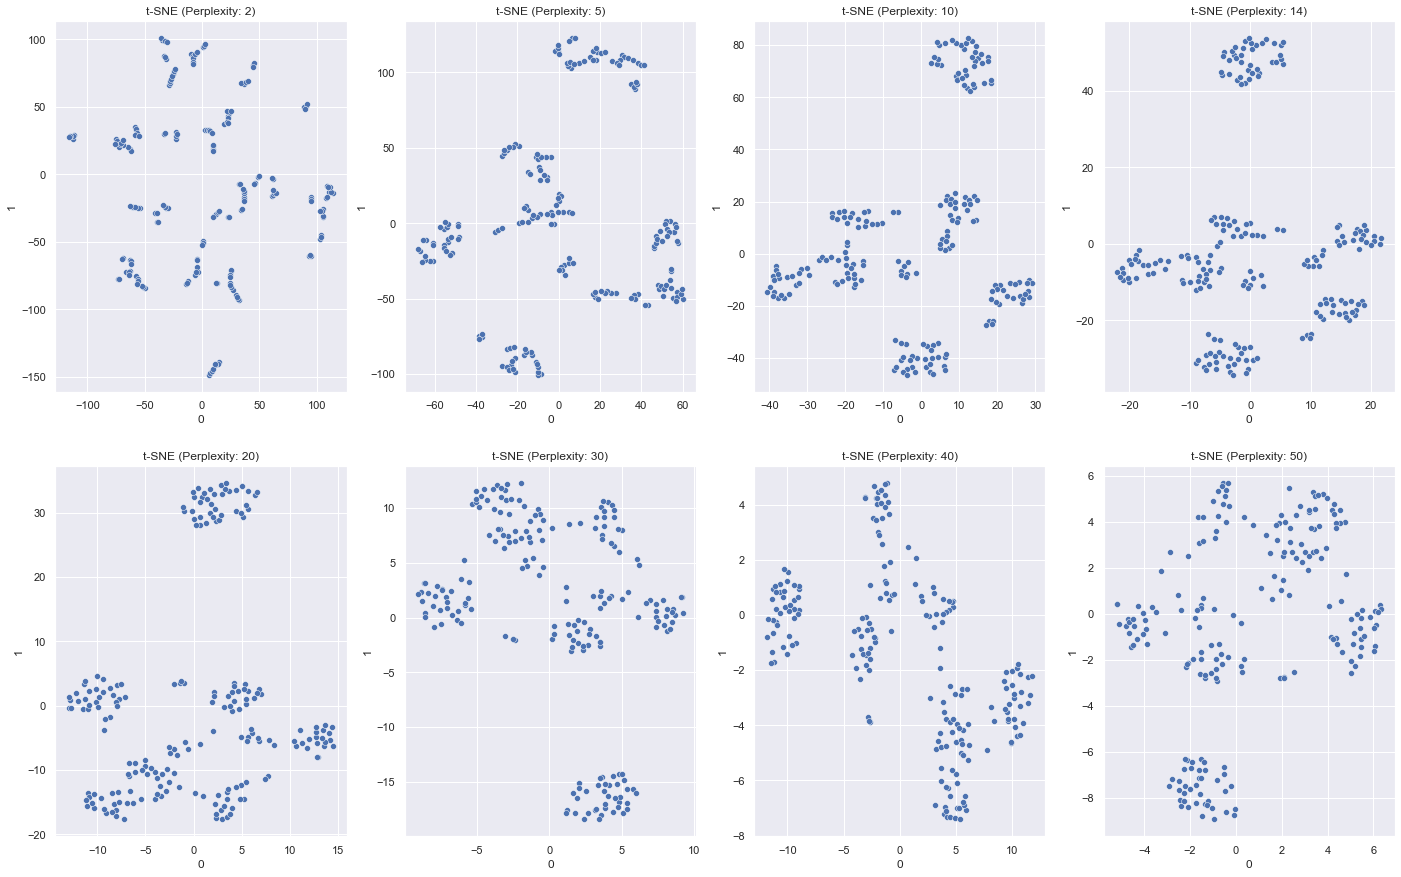

In [27]:
eda_pca_tsneplot = plot_tsne(pca_scores, [2, 5, 10, round(np.sqrt(200)), 20, 30, 40, 50], n_iter=5000)
eda_pca_tsneplot.plot([], centroids=False, ncols=4, nrows=2, figsize=(24, 15))

In [28]:
pca_tsneplot = plot_tsne(pca_scores, [round(np.sqrt(200)), 30], n_iter=5000)

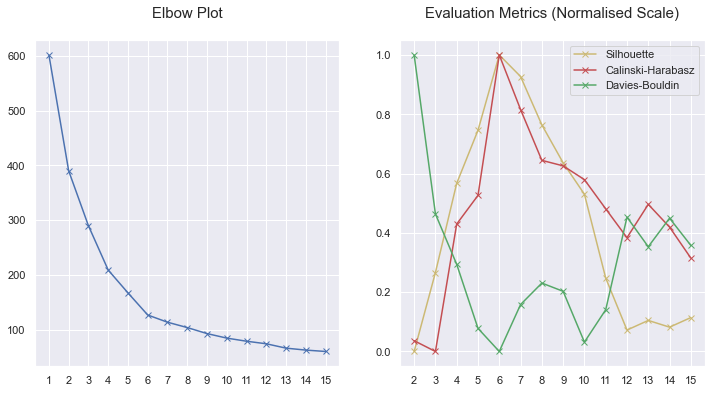

Optimal Number of Clusters for k-means++-pca (Silhouette): 6
Optimal Number of Clusters for k-means++-pca (Calinski-Harabasz): 6
Optimal Number of Clusters for k-means++-pca (Davies-Bouldin): 6


In [47]:
init_scoring("k-means++-pca")

for k in range(1,n_clusters):
    model = KMeans(n_clusters=k, random_state=23, init="k-means++")
    model.fit(pca_scores) #index [0] for column 'Age'
    scores["wcss"]["k-means++-pca"][k] = model.inertia_
    if k >= 2:
        labels = model.labels_
        set_scores("k-means++-pca", k, pca_scores, labels)

fig, ax = eval_plots("k-means++-pca", figsize=(12,6))

plt.show()

optimal_n_cluster("k-means++-pca")

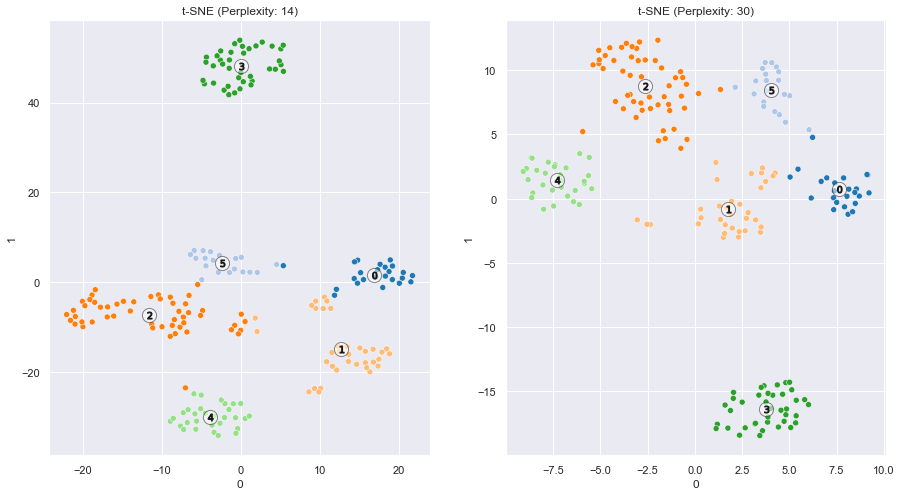

In [48]:
model = KMeans(n_clusters=6, random_state=23, init="k-means++")
model.fit(pca_scores)
labels = model.labels_
pca_tsneplot.plot([str(x) for x in labels], ncols=2, nrows=1, figsize=(15, 8))

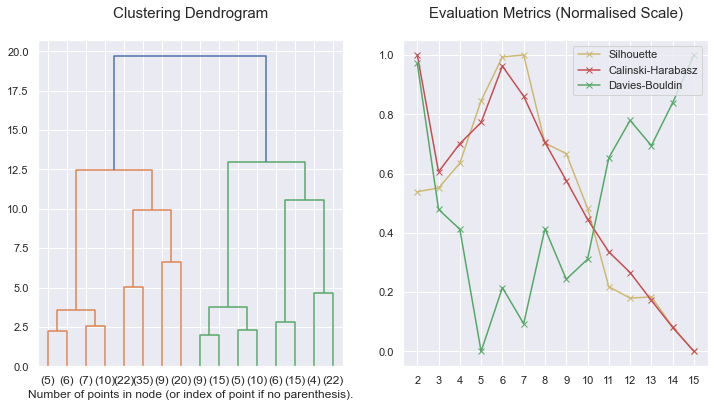

Optimal Number of Clusters for agglomerative-pca (Silhouette): 7
Optimal Number of Clusters for agglomerative-pca (Calinski-Harabasz): 2
Optimal Number of Clusters for agglomerative-pca (Davies-Bouldin): 5


In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

init_scoring("agglomerative-pca")

for k in range(2,n_clusters):
    model = AgglomerativeClustering(n_clusters=k)
    model.fit_predict(pca_scores) #index [0] for column 'Age'
    labels = model.labels_
    set_scores("agglomerative-pca", k, transformed_features, labels)

axes[1].plot(list(scores["silhouette"]["agglomerative-pca"].keys()), normalise(list(scores["silhouette"]["agglomerative-pca"].values())), 'yx-', label="Silhouette")
axes[1].plot(list(scores["calinski_harabasz"]["agglomerative-pca"].keys()), normalise(list(scores["calinski_harabasz"]["agglomerative-pca"].values())), 'rx-', label="Calinski-Harabasz")
axes[1].plot(list(scores["davies_bouldin"]["agglomerative-pca"].keys()), normalise(list(scores["davies_bouldin"]["agglomerative-pca"].values())), 'gx-', label="Davies-Bouldin")
axes[1].set_title('Evaluation Metrics (Normalised Scale)\n', fontsize = 15)
axes[1].set_xticks(list(scores["silhouette"]["agglomerative-pca"].keys()), labels=[str(x) for x in scores["silhouette"]["agglomerative-pca"].keys()])

from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(pca_scores)
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3, ax=axes[0])
axes[0].set_title("Clustering Dendrogram\n", fontdict={'fontsize': 15})
axes[0].set_xlabel("Number of points in node (or index of point if no parenthesis).")

plt.legend()
plt.show()

optimal_n_cluster("agglomerative-pca")

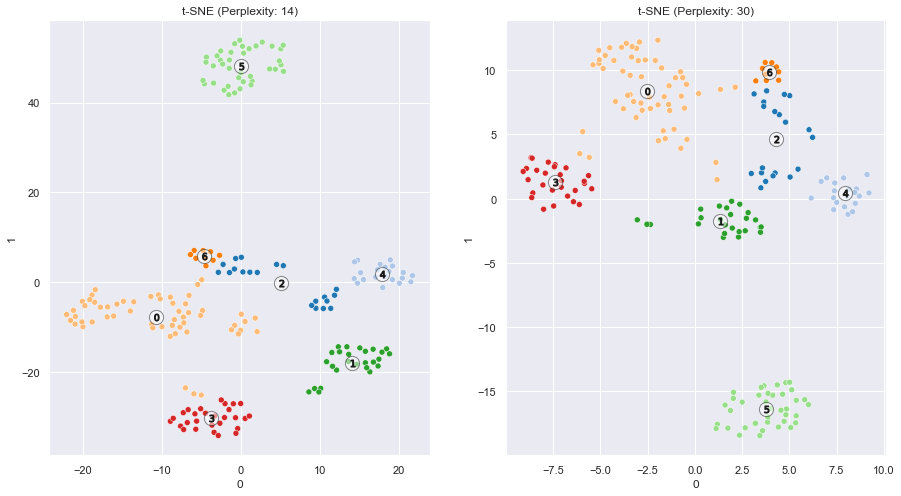

In [50]:
model = AgglomerativeClustering(n_clusters=7)
model.fit_predict(pca_scores) #index [0] for column 'Age'
labels = model.labels_
pca_tsneplot.plot([str(x) for x in labels], ncols=2, nrows=1, figsize=(15, 8))

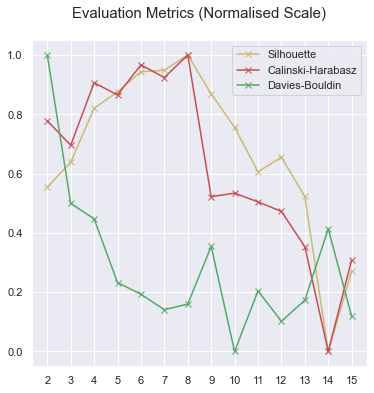

Optimal Number of Clusters for spectral-pca (Silhouette): 8
Optimal Number of Clusters for spectral-pca (Calinski-Harabasz): 8
Optimal Number of Clusters for spectral-pca (Davies-Bouldin): 10


In [51]:
init_scoring("spectral-pca")

for k in range(2,n_clusters):
    model = SpectralClustering(n_clusters=k, random_state=23)
    model.fit_predict(pca_scores) #index [0] for column 'Age'
    labels = model.labels_
#     scores["wcss"]["spectral"][k] = compute_wcss(model.affinity_matrix_, label)
    set_scores("spectral-pca", k, pca_scores, labels)

fig, axes = eval_plots("spectral-pca", plot_elbow=False, figsize=(6,6))

plt.show()

optimal_n_cluster("spectral-pca")

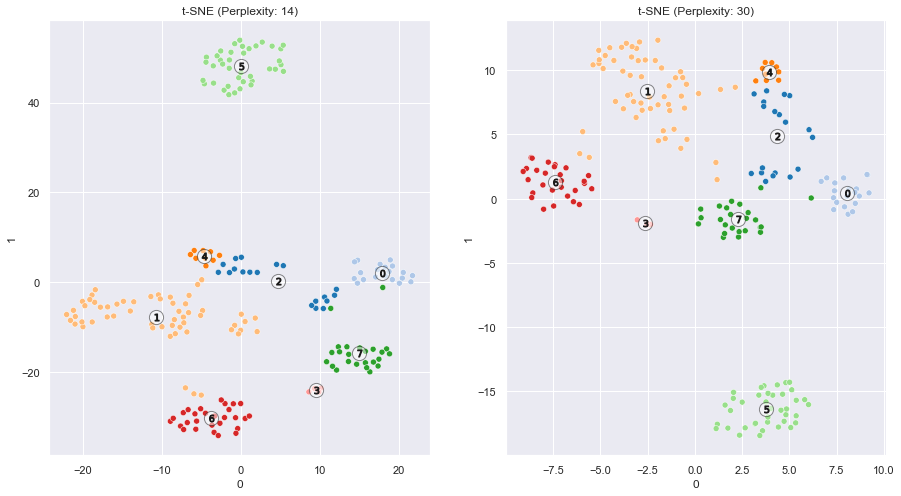

In [52]:
model = SpectralClustering(n_clusters=8, random_state=23)
model.fit(pca_scores)
labels = model.labels_
pca_tsneplot.plot([str(x) for x in labels], ncols=2, nrows=1, figsize=(15, 8))

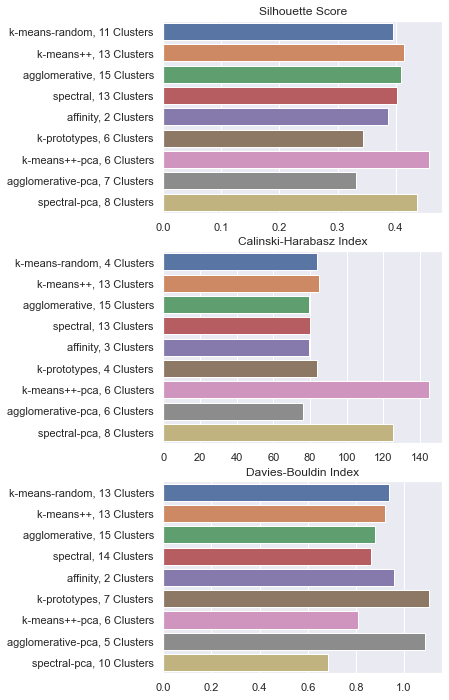

In [53]:
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(5, 12))

silhouette_scores_df = pd.DataFrame(scores['silhouette'])
silhouette_scores_df = silhouette_scores_df.drop("dbscan", axis=1).dropna()
corresponding_n_clusters = [silhouette_scores_df.index[np.argmax(silhouette_scores_df[column])] for column in silhouette_scores_df.columns]
sns.barplot(x=np.max(silhouette_scores_df), y=[f"{x}, {int(n)} Clusters" for x, n in zip(np.max(silhouette_scores_df).index, corresponding_n_clusters)], ax=axes[0])
axes[0].set_title("Silhouette Score")


ch_scores_df = pd.DataFrame(scores['calinski_harabasz'])
ch_scores_df = ch_scores_df.drop("dbscan", axis=1).dropna()
# Dropping the scores for 2 clusters since it seems to consistently be the highest score for all clustering algorithms with this metric which may not be the most suitable.
ch_scores_df = ch_scores_df.drop(2)
corresponding_n_clusters = [ch_scores_df.index[np.argmax(ch_scores_df[column])] for column in ch_scores_df.columns]
sns.barplot(x=np.max(ch_scores_df), y=[f"{x}, {int(n)} Clusters" for x, n in zip(np.max(ch_scores_df).index, corresponding_n_clusters)], ax=axes[1])
axes[1].set_title("Calinski-Harabasz Index")


db_scores_df = pd.DataFrame(scores['davies_bouldin'])
db_scores_df = db_scores_df.drop("dbscan", axis=1).dropna()
corresponding_n_clusters = [db_scores_df.index[np.argmin(db_scores_df[column])] for column in db_scores_df.columns]
sns.barplot(x=np.min(db_scores_df), y=[f"{x}, {int(n)} Clusters" for x, n in zip(np.min(db_scores_df).index, corresponding_n_clusters)], ax=axes[2])
axes[2].set_title("Davies-Bouldin Index")


plt.show()

**Observations**
* The clustering metrics are not always comparable when performed on different datasets. 
* Focussing on those that use the data with reduced dimensions, 
    * K-Means with k-means++ initialisation performs the best based on Silhouette score and Calinski-Harabasz index
    * Spectral Clustering performs the best based on Davies-Bouldin index.

# Model Improvement

## Hyperparameter Tuning

In [200]:
from tqdm.notebook import tqdm
def optimal_clusters(X, model, params):
    clusters = range(2,16)
    sil = []
    model = model()
    for k in clusters:
#         print(model)
        model.set_params(**params, n_clusters=k)
#         print(model.get_params())
        model.fit_predict(X, categorical=[3]) #index [0] for column 'Age'
        labels = model.labels_
        sil.append(silhouette_score(X, labels))
#     print(np.max(sil))
    return np.max(sil), clusters[np.argmax(sil)]
        
models = [
    {
        'model': KMeans,
        'grid': {
            'init': ['k-means++', 'random'],
            'n_init': [1, 10, 20],
            'max_iter': [300, 600, 900],
            'tol': [0.0001, 0.000001],
            'algorithm': ["lloyd", "elkan"],
            'random_state': [23]
        }
        
    },
    {
        'model': SpectralClustering,
        'grid': {
#             'eigen_solver': ['arpack', 'lobpcg', 'amg'],
            'eigen_solver': ['arpack', 'lobpcg'],
            'n_components': [5, 10, 20, None],
            'affinity': ['nearest_neighbors', 'rbf'],
            'n_neighbors': [2, 5, 10],
            'assign_labels': ['kmeans', 'discretize', 'cluster_qr'],
            'random_state': [23]
        }
    },
    {
        'model': AgglomerativeClustering,
        'grid': {
            'metric': ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'dice', 'hamming', 'jaccard', 'kulsinski', 'minkowski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule'],
            'linkage': ['complete', 'average', 'single']
        }
    },
    {
        'model': KPrototypes,
        'grid': {
            'max_iter': [300, 600, 900],
            'n_init': [1, 10, 20],
            'init': ['Huang', 'Cao', 'random']
        }
    }
]


best = {"score": -1, "params": {}, "k": 0}

for model in models[-1:]:
    best = {"score": -1, "params": {}, "k": 0}
    for params in tqdm(ParameterGrid(model["grid"])):
        sil, k = optimal_clusters(transformed_features_df, model["model"], params)
        if sil > best["score"]:
            best["score"] = sil
            best["params"] = params
            best["k"] = k
    print(best)

  0%|          | 0/27 [00:00<?, ?it/s]

{'score': 0.42102871967968825, 'params': {'init': 'Cao', 'max_iter': 300, 'n_init': 20}, 'k': 15}


### Results

**Original data**

KMeans <br>
```{'score': 0.41507964309559786, 'params': {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_init': 10, 'tol': 0.0001}, 'k': 13}``` <br>
Spectral <br>
```{'score': 0.4136461318301004, 'params': {'affinity': 'rbf', 'assign_labels': 'discretize', 'eigen_solver': 'arpack', 'n_components': None, 'n_neighbors': 2}, 'k': 13}```<br>
Agglomerative <br>
```{'score': 0.413039633961778, 'params': {'linkage': 'average', 'metric': 'cityblock'}, 'k': 15}```<br>
K-Prototypes <br>
```{'score': 0.42102871967968825, 'params': {'init': 'Cao', 'max_iter': 300, 'n_init': 20}, 'k': 15}```


**PCA data**

KMeans <br>
```{'score': 0.45744844863127626, 'params': {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_init': 10, 'tol': 0.0001}, 'k': 6}``` <br>
Spectral <br>
```{'score': 0.45744844863127626, 'params': {'affinity': 'rbf', 'assign_labels': 'discretize', 'eigen_solver': 'arpack', 'n_components': None, 'n_neighbors': 2}, 'k': 6}```<br>
Agglomerative <br>
```{'score': 0.4474710510188475, 'params': {'linkage': 'average', 'metric': 'cityblock'}, 'k': 8}```<br>

Based on the identical silhouette score from KMeans and Spectral Clustering on the reduced PCA data, it is likely that the models produced the same clusters.

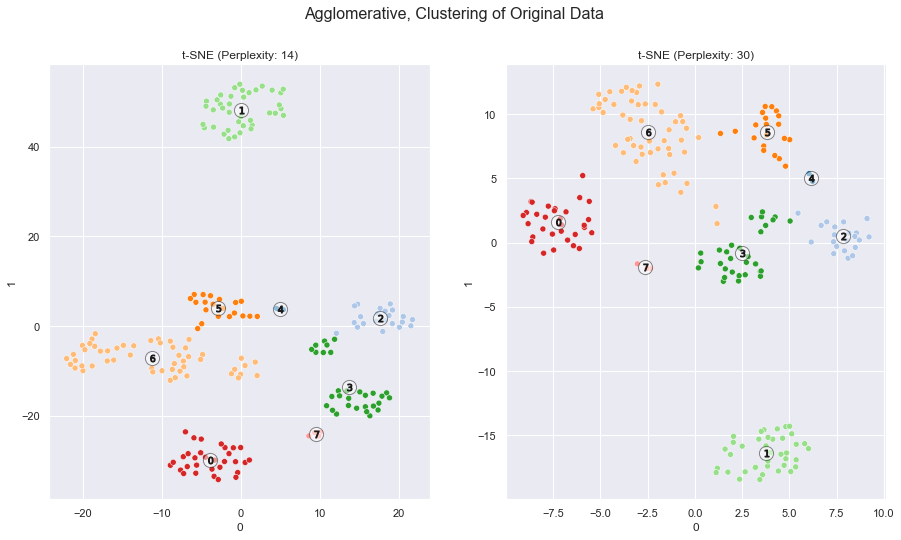

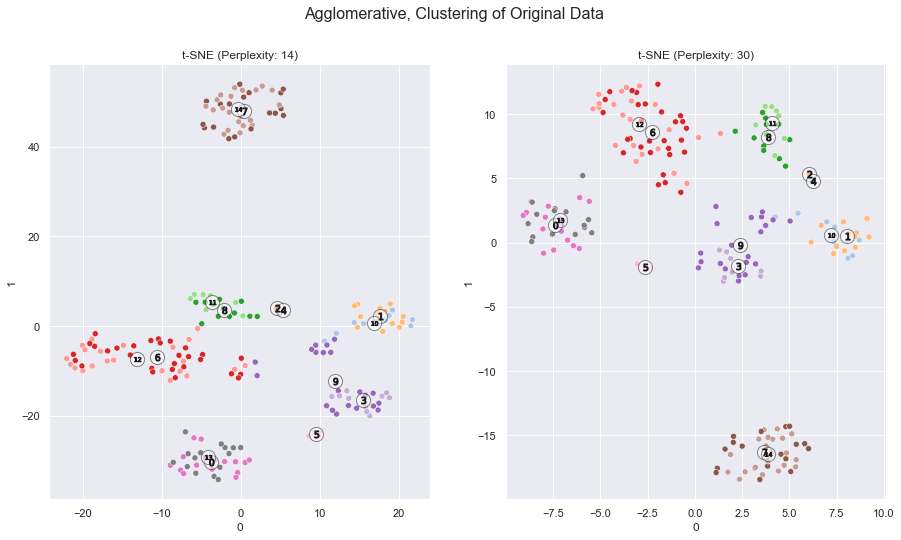

In [207]:
model = AgglomerativeClustering(n_clusters=8, **{'linkage': 'average', 'metric': 'cityblock'})
model.fit_predict(pca_scores) #index [0] for column 'Age'
labels_aggl_pca_8 = model.labels_
pca_tsneplot.plot([str(x) for x in labels_aggl_pca_8], ncols=2, title="Agglomerative, Clustering of Original Data", nrows=1, figsize=(15, 8))

model = AgglomerativeClustering(n_clusters=15, **{'linkage': 'average', 'metric': 'cityblock'})
model.fit_predict(transformed_features_df) #index [0] for column 'Age'
labels_aggl_ori_15 = model.labels_
pca_tsneplot.plot([str(x) for x in labels_aggl_ori_15], ncols=2, title="Agglomerative, Clustering of Original Data", nrows=1, figsize=(15, 8))

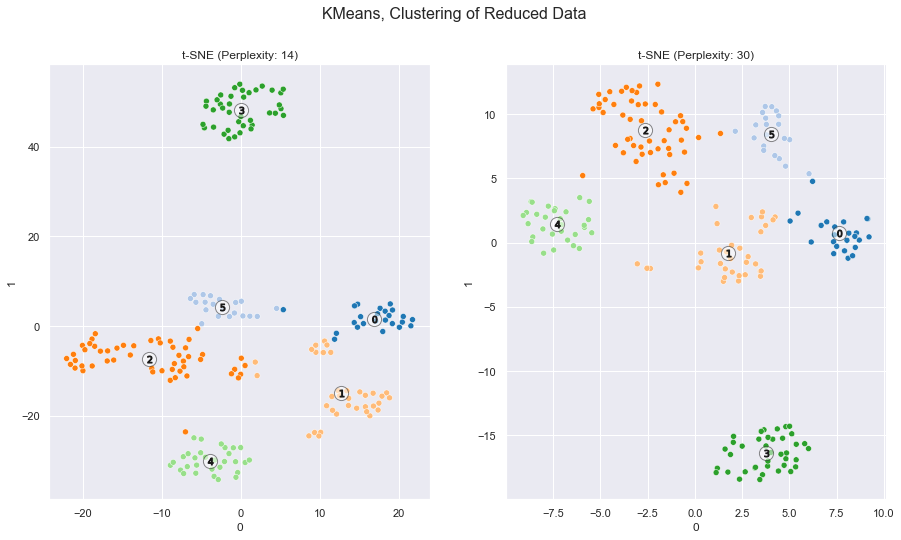

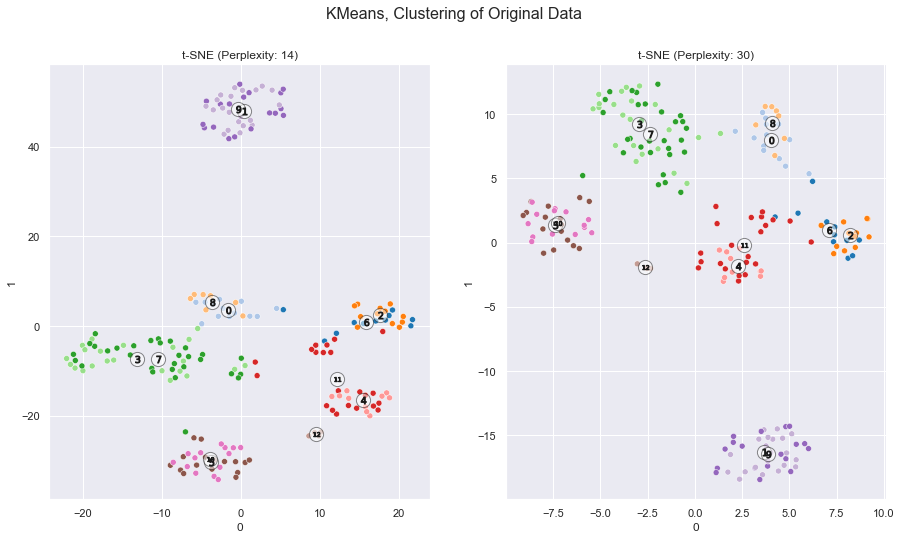

In [210]:
model = KMeans(n_clusters=6, random_state=23, **{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_init': 10, 'tol': 0.0001})
model.fit_predict(pca_scores) #index [0] for column 'Age'
labels_kmeans_pca_6 = model.labels_
pca_tsneplot.plot([str(x) for x in labels_kmeans_pca_6], ncols=2, title="KMeans, Clustering of Reduced Data", nrows=1, figsize=(15, 8))

model = KMeans(n_clusters=13, random_state=23, **{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_init': 10, 'tol': 0.0001})
model.fit_predict(transformed_features_df) #index [0] for column 'Age'
labels_kmeans_ori_13 = model.labels_
pca_tsneplot.plot([str(x) for x in labels_kmeans_ori_13], ncols=2, title="KMeans, Clustering of Original Data", nrows=1, figsize=(15, 8))

Since the two PCs removed during PCA were mainly about Gender, Gender plays no longer plays a role in the clustering of the reduced data. As seen from using optimal clustering from the original data on the t-SNE plot of the reduced data.

In [57]:
old_scores = scores

In [58]:
scores = {
    "wcss": {}, 
    "silhouette": {},
    "calinski_harabasz": {},
    "davies_bouldin": {}
}

init_scoring("k-means++-tuned")
init_scoring("kprototypes-tuned")
init_scoring("agglomerative-tuned")

for k in range(2,n_clusters):
    model = KMeans(n_clusters=k, random_state=23, **{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_init': 10, 'tol': 0.0001})
    model.fit_predict(transformed_features_df) #index [0] for column 'Age'
    labels = model.labels_
    set_scores("k-means++-tuned", k, transformed_features_df, labels)
    
for k in range(2,n_clusters):
    model = KPrototypes(n_clusters=k, random_state=23, **{'init': 'Cao', 'max_iter': 300, 'n_init': 20})
    model.fit_predict(transformed_features_df, categorical=[3]) #index [0] for column 'Age'
    labels = model.labels_
    set_scores("kprototypes-tuned", k, transformed_features_df, labels)

for k in range(2,n_clusters):
    model = AgglomerativeClustering(n_clusters=k, **{'linkage': 'average', 'metric': 'cityblock'})
    model.fit_predict(transformed_features_df) #index [0] for column 'Age'
    labels = model.labels_
    set_scores("agglomerative-tuned", k, transformed_features_df, labels)

init_scoring("k-means++-pca-tuned")
# init_scoring("spectral-pca-tuned")
init_scoring("agglomerative-pca-tuned")

for k in range(2,n_clusters):
    model = KMeans(n_clusters=k, random_state=23, **{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_init': 10, 'tol': 0.0001})
    model.fit_predict(pca_scores) #index [0] for column 'Age'
    labels = model.labels_
    set_scores("k-means++-pca-tuned", k, pca_scores, labels)
    
# for k in range(2,n_clusters):
#     model = SpectralClustering(n_clusters=k, random_state=23, **{'affinity': 'rbf', 'assign_labels': 'discretize', 'eigen_solver': 'arpack', 'n_components': None, 'n_neighbors': 2})
#     model.fit_predict(pca_scores) #index [0] for column 'Age'
#     labels = model.labels_
#     set_scores("spectral-pca-tuned", k, pca_scores, labels)

for k in range(2,n_clusters):
    model = AgglomerativeClustering(n_clusters=k, **{'linkage': 'average', 'metric': 'cityblock'})
    model.fit_predict(pca_scores) #index [0] for column 'Age'
    labels = model.labels_
    set_scores("agglomerative-pca-tuned", k, pca_scores, labels)

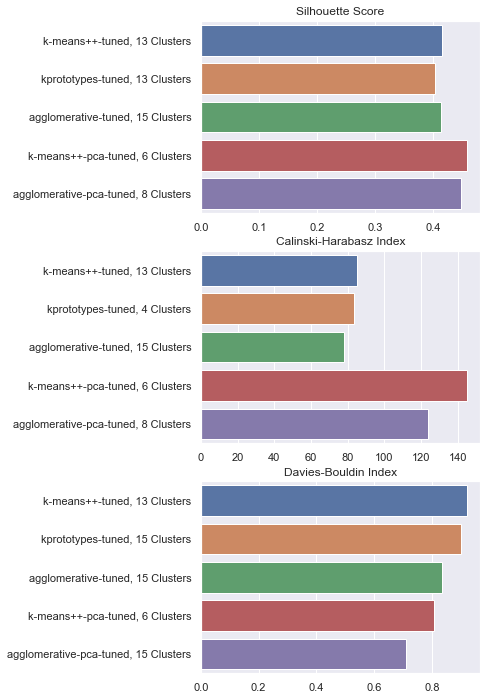

In [59]:
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(5, 12))

silhouette_scores_df = pd.DataFrame(scores['silhouette'])
# silhouette_scores_df = silhouette_scores_df.drop("dbscan", axis=1).dropna()
corresponding_n_clusters = [silhouette_scores_df.index[np.argmax(silhouette_scores_df[column])] for column in silhouette_scores_df.columns]
sns.barplot(x=np.max(silhouette_scores_df), y=[f"{x}, {int(n)} Clusters" for x, n in zip(np.max(silhouette_scores_df).index, corresponding_n_clusters)], ax=axes[0])
axes[0].set_title("Silhouette Score")


ch_scores_df = pd.DataFrame(scores['calinski_harabasz'])
# ch_scores_df = ch_scores_df.drop("dbscan", axis=1).dropna()
# Dropping the scores for 2 clusters since it seems to consistently be the highest score for all clustering algorithms with this metric which may not be the most suitable.
ch_scores_df = ch_scores_df.drop(2)
corresponding_n_clusters = [ch_scores_df.index[np.argmax(ch_scores_df[column])] for column in ch_scores_df.columns]
sns.barplot(x=np.max(ch_scores_df), y=[f"{x}, {int(n)} Clusters" for x, n in zip(np.max(ch_scores_df).index, corresponding_n_clusters)], ax=axes[1])
axes[1].set_title("Calinski-Harabasz Index")


db_scores_df = pd.DataFrame(scores['davies_bouldin'])
# db_scores_df = db_scores_df.drop("dbscan", axis=1).dropna()
corresponding_n_clusters = [db_scores_df.index[np.argmin(db_scores_df[column])] for column in db_scores_df.columns]
sns.barplot(x=np.min(db_scores_df), y=[f"{x}, {int(n)} Clusters" for x, n in zip(np.min(db_scores_df).index, corresponding_n_clusters)], ax=axes[2])
axes[2].set_title("Davies-Bouldin Index")


plt.show()

In [61]:
silhouette_scores_df

,k-means++-tuned,kprototypes-tuned,agglomerative-tuned,k-means++-pca-tuned,agglomerative-pca-tuned
2,0.285051,0.285051,0.253764,0.338899,0.247040
3,0.299764,0.299764,0.220235,0.370469,0.316010
4,0.319551,0.320427,0.269975,0.406138,0.258664
5,0.327901,0.329178,0.260071,0.427337,0.327561
6,0.344045,0.344045,0.267402,0.457448,0.378693
7,0.344089,0.342638,0.286450,0.448832,0.410368
8,0.347408,0.350488,0.287228,0.429488,0.447471
9,0.367114,0.364807,0.319468,0.414313,0.432007
10,0.384634,0.381110,0.329442,0.401774,0.422354
11,0.396022,0.390827,0.325698,0.368274,0.400379


## Conclusion

Based on the evaluation metrics I used and the t-SNE visualisation of the clusters, I believe that 6 is the optimal number of clusters. While clustering on the original dataset gave 13 as the optimal number of clusters, that may be due to my choice of scaling for the Gender columns. The 13 clusters is nearly equivalent to splitting each of the 6 clusters further by Gender.

In [211]:
end_ct = ColumnTransformer(
    transformers=[
        ("one_hot_encoder", OneHotEncoder(sparse_output=False), ["Gender"])
    ],
    remainder="passthrough"
)

end_df = df.copy()
end = end_ct.fit_transform(end_df)
end_df = pd.DataFrame(end, columns=["Gender_Female", "Gender_Male", 'Age', 'Income (k$)', 'How Much They Spend'])

end_df.head(5)
# end_df = end_df.drop(columns="Gender_Male")

,Gender_Female,Gender_Male,Age,Income (k$),How Much They Spend
0,0.0,1.0,19.0,15.0,39.0
1,0.0,1.0,21.0,15.0,81.0
2,1.0,0.0,20.0,16.0,6.0
3,1.0,0.0,23.0,16.0,77.0
4,1.0,0.0,31.0,17.0,40.0


### Surrogate Model: Decision Tree

To better quantify the clustering, a Decision Tree can be used as a surrogate model for us to better understand the decision rule by which each cluster is associated.

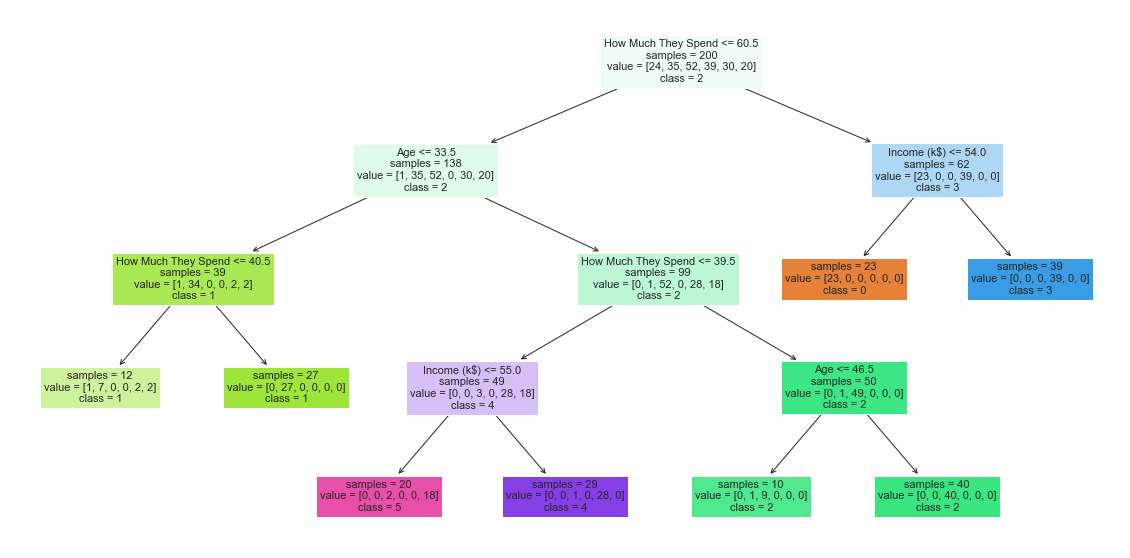

In [212]:
# model = KMeans(n_clusters=13, random_state=23, init="k-means++")
# model.fit(transformed_features_df)
# labels = model.labels_
# tsneplot.plot([str(x) for x in labels], title="K-Means, 13 Clusters", ncols=2, nrows=1, figsize=(15, 8))

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

clf = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)

clf.fit(end_df, labels_kmeans_pca_6)

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(
    clf,
    feature_names=end_df.columns,
    class_names=[str(x) for x in np.unique(labels_kmeans_pca_6)],
    impurity=False,
    filled=True,
    ax=ax,
    fontsize=11,
)
plt.show()

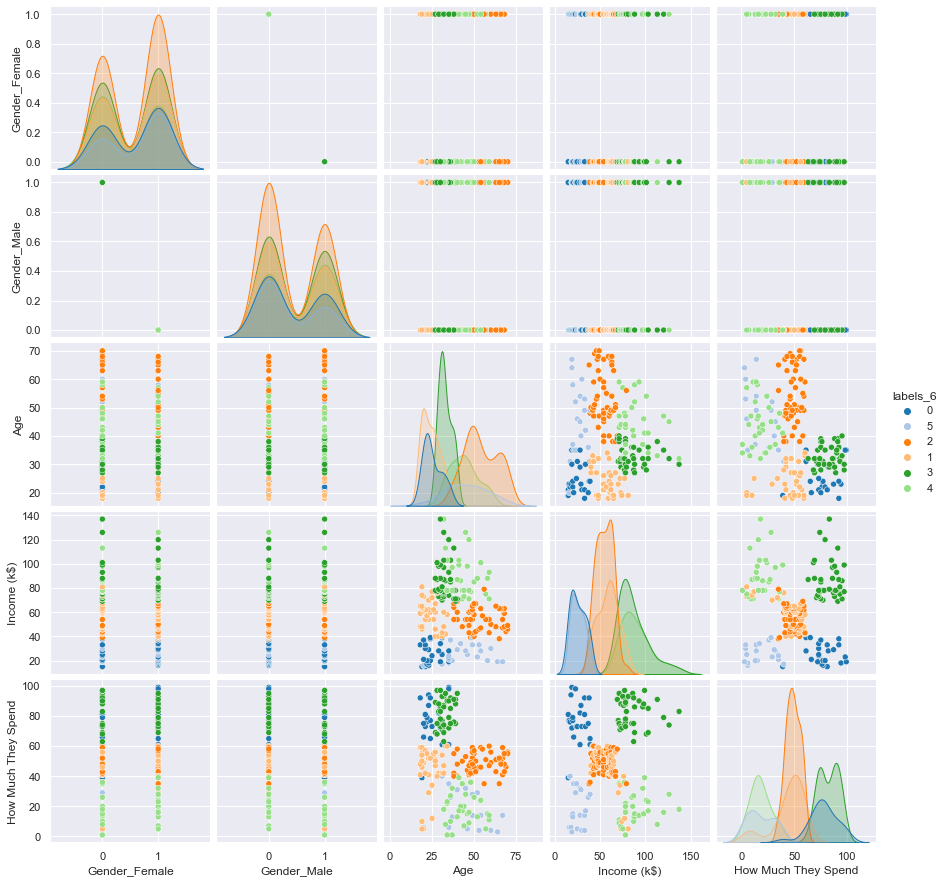

In [215]:
end_df["labels_6"] = [str(x) for x in labels_kmeans_pca_6]
end_df["labels_13"] = [str(x) for x in labels_kmeans_ori_13]
end_df["labels_8"] = [str(x) for x in labels_aggl_pca_8]
end_df["labels_15"] = [str(x) for x in labels_aggl_ori_15]

# plt.figure(figsize=(15, 15))

sns.pairplot(end_df, kind="scatter", diag_kind="kde", hue="labels_6", palette="tab20")

plt.show()

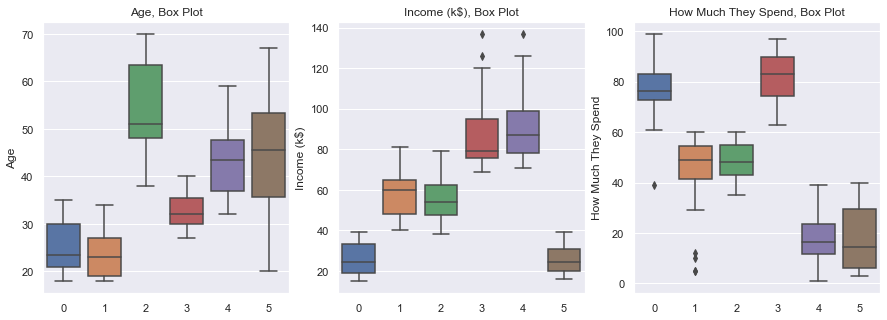

In [216]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for ax, col in zip(axes, numeric_columns):
    sns.boxplot(x=labels_kmeans_pca_6, y=df[col], ax=ax)
    ax.set_title(f'{col}, Box Plot')
    
plt.show()

In [217]:
clustering_6_df = []
count = []

for i in np.unique(end_df["labels_6"]):
    clustering_6_df.append(dict(round(end_df[end_df["labels_6"] == i].drop(columns=["labels_6", "labels_13", "labels_8", "labels_15"]).mean(), 2)))
    count.append(len(end_df[end_df["labels_6"] == i]))
    
clustering_6_df = pd.DataFrame(clustering_6_df)
clustering_6_df["Gender_Male"] = clustering_6_df["Gender_Male"]/np.mean(df["Gender"] == "Male")
clustering_6_df["Gender_Female"] = clustering_6_df["Gender_Female"]/np.mean(df["Gender"] == "Female")
clustering_6_df["Count"] = count
    
clustering_13_df = []
count = []

for i in np.unique(end_df["labels_13"]):
    clustering_13_df.append(dict(round(end_df[end_df["labels_13"] == i].drop(columns=["labels_6", "labels_13", "labels_8", "labels_15"]).mean(), 2)))
    count.append(len(end_df[end_df["labels_13"] == i]))
    
clustering_13_df = pd.DataFrame(clustering_13_df)
clustering_13_df["Gender"] = clustering_13_df["Gender_Female"].map(lambda x: "Female" if x == 1 else "Male")
clustering_13_df = clustering_13_df.drop(columns=["Gender_Female", "Gender_Male"])
clustering_13_df["Count"] = count

clustering_8_df = []
count = []

for i in np.unique(end_df["labels_8"]):
    clustering_8_df.append(dict(round(end_df[end_df["labels_8"] == i].drop(columns=["labels_6", "labels_13", "labels_8", "labels_15"]).mean(), 2)))
    count.append(len(end_df[end_df["labels_8"] == i]))
    
clustering_8_df = pd.DataFrame(clustering_8_df)
clustering_8_df["Gender_Male"] = clustering_8_df["Gender_Male"]/np.mean(df["Gender"] == "Male")
clustering_8_df["Gender_Female"] = clustering_8_df["Gender_Female"]/np.mean(df["Gender"] == "Female")
clustering_8_df["Count"] = count
    
clustering_15_df = []
count = []

for i in np.unique(end_df["labels_15"]):
    clustering_15_df.append(dict(round(end_df[end_df["labels_15"] == i].drop(columns=["labels_6", "labels_13", "labels_8", "labels_15"]).mean(), 2)))
    count.append(len(end_df[end_df["labels_15"] == i]))
    
clustering_15_df = pd.DataFrame(clustering_15_df)
clustering_15_df["Gender"] = clustering_15_df["Gender_Female"].map(lambda x: "Female" if x == 1 else "Male")
clustering_15_df = clustering_15_df.drop(columns=["Gender_Female", "Gender_Male"])
clustering_15_df["Count"] = count

### Cluster Interpretation: K-Means

In [218]:
clustering_6_df.sort_values("How Much They Spend", ascending=False)

,Gender_Female,Gender_Male,Age,Income (k$),How Much They Spend,Count
3,0.964286,1.045455,32.69,86.54,82.13,39
0,1.035714,0.954545,25.25,25.83,76.92,24
2,1.035714,0.954545,54.17,54.79,48.60,52
1,1.017857,0.977273,24.11,58.60,44.43,35
5,1.160714,0.795455,45.40,25.65,18.55,20
4,0.839286,1.204545,44.00,90.13,17.93,30


**Cluster 0: "Young Spenders"**

Demographic: Young (Average Age: 25.25), Low to Moderate Income (25.83 k$), High Spending (76.92)
Interpretation: This cluster represents young individuals with relatively lower income who spend a significant portion of their income. They might be early in their careers or education and prioritize spending on various products.


**Cluster 1: "Economical Shoppers"**

Demographic: Young (Average Age: 24.11), Moderate Income (58.60 k$), Moderate Spending (44.43)
Interpretation: This cluster consists of individuals who are relatively young and have moderate income. While they do spend, they tend to be more cautious and economical in their spending habits.


**Cluster 2: "Mid-Age Budgeters"**

Demographic: Mid-Age (Average Age: 54.17), Moderate Income (54.79 k$), Moderate Spending (48.60)
Interpretation: This cluster includes individuals in their mid-age years who have moderate income and spending patterns. They may have established financial responsibilities and make reasonable but not excessive purchases.


**Cluster 3: "Affluent Shoppers"**

Demographic: Young (Average Age: 32.69), High Income (86.54 k$), Very High Spending (82.13)
Interpretation: This cluster represents affluent individuals, both young and mid-age, who have high incomes and consequently high spending patterns. They likely prioritize quality and luxury in their purchases.


**Cluster 4: "High-Income Savers"**

Demographic: Mid-Age (Average Age: 44.00), High Income (90.13 k$), Low Spending (17.93)
Interpretation: This cluster consists of mid-age individuals, moreso males, with high incomes but relatively low spending patterns. They might be more conservative in their spending and focus on savings or specific investments.


**Cluster 5: "Frugal Shoppers"**

Demographic: Mid-Age (Average Age: 45.40), Low Income (25.65 k$), Very Low Spending (18.55)
Interpretation: This cluster represents individuals, especially females, with mid-age and relatively lower incomes. They exhibit frugal spending habits and are careful with their purchases.

### Cluster Interpretation: Agglomerative

In [219]:
clustering_8_df.sort_values("How Much They Spend", ascending=False)

,Gender_Female,Gender_Male,Age,Income (k$),How Much They Spend,Count
1,0.964286,1.045455,32.69,86.54,82.13,39
2,1.053571,0.931818,25.27,25.73,79.36,22
3,1.125000,0.840909,24.20,55.57,49.40,30
6,1.071429,0.909091,53.44,54.79,49.19,52
4,0.892857,1.136364,19.50,15.50,22.50,2
5,1.071429,0.909091,46.80,26.80,20.05,20
0,0.857143,1.181818,44.39,89.77,18.48,31
7,0.000000,2.272727,20.75,76.25,8.00,4


It features the 6 clusters from above with nearly identical demographics with an additional 2 clusters.

**Cluster 2: "Young Spenders"**

Demographic: Young (Average Age: 25.27), Low to Moderate Income (25.73 k$), High Spending (79.36)
Interpretation: This cluster represents young individuals with relatively lower income who spend a significant portion of their income. They might be early in their careers or education and prioritize spending on various products.


**Cluster 3: "Economical Shoppers"**

Demographic: Young (Average Age: 24.20), Moderate Income (55.57 k$), Moderate Spending (49.40)
Interpretation: This cluster consists of individuals who are relatively young and have moderate income. While they do spend, they tend to be more cautious and economical in their spending habits.


**Cluster 6: "Mid-Age Budgeters"**

Demographic: Mid-Age (Average Age: 53.44), Moderate Income (54.79 k$), Moderate Spending (49.19)
Interpretation: This cluster includes individuals in their mid-age years who have moderate income and spending patterns. They may have established financial responsibilities and make reasonable but not excessive purchases.


**Cluster 1: "Affluent Shoppers"**

Demographic: Young (Average Age: 32.69), High Income (86.54 k$), Very High Spending (82.13)
Interpretation: This cluster represents affluent individuals, both young and mid-age, who have high incomes and consequently high spending patterns. They likely prioritize quality and luxury in their purchases.


**Cluster 0: "High-Income Savers"**

Demographic: Mid-Age (Average Age: 44.39), High Income (89.77 k$), Low Spending (18.48)
Interpretation: This cluster consists of mid-age individuals, moreso males, with high incomes but relatively low spending patterns. They might be more conservative in their spending and focus on savings or specific investments.


**Cluster 5: "Frugal Shoppers"**

Demographic: Mid-Age (Average Age: 46.80), Low Income (26.80 k$), Very Low Spending (20.05)
Interpretation: This cluster represents individuals, especially females, with mid-age and relatively lower incomes. They exhibit frugal spending habits and are careful with their purchases.


**Cluster 4: "Young Frugal Shoppers"**

Demographic: Very Young (Average Age: 19.50), Very Low Income (15.50 k$), Low Spending (22.50)
Interpretation: This cluster consists primarily of very young individuals, mostly males, with very low income and relatively conservative spending patterns. They exhibit frugal behaviors, likely due to financial constraints or early financial independence.


**Cluster 7: "Outlier Spenders"**

Demographic: Primarily Males, Very Young (Average Age: 20.75), High Income (76.25 k$), Very High Spending (8.00)
Interpretation: This cluster consists exclusively of very young males with high income and extremely high spending patterns. They appear to be outliers with exceptional spending behaviors that deviate significantly from the rest of the groups.

### Relevant Insight
One of the primary goals of this clustering task: <br>
Which group of customer is the most valuable to the shopping mall so that the
shopping mall should do something to retain them.

The group of customer that is the most valuable to the shopping mall are the **Affluent Shoppers**, made up of young to mid-age individuals who are high-income and big spenders, from both genders.

-------------------------

K-Means and Agglomerative clusters of the non-reduced dataset

In [154]:
clustering_13_df.sort_values("How Much They Spend", ascending=False)

,Age,Income (k$),How Much They Spend,Gender,Count
1,33.28,87.11,82.67,Male,18
2,25.58,24.58,81.83,Female,12
9,32.19,86.05,81.67,Female,21
6,25.18,26.27,72.55,Male,11
4,21.60,56.90,52.60,Male,10
3,56.95,53.59,48.82,Male,22
7,52.13,55.67,48.43,Female,30
11,25.77,55.14,48.32,Female,22
0,41.54,26.54,20.69,Female,13
10,43.79,93.29,20.64,Female,14


In [157]:
clustering_15_df.sort_values("How Much They Spend", ascending=False)

,Age,Income (k$),How Much They Spend,Gender,Count
7,33.28,87.11,82.67,Male,18
14,32.19,86.05,81.67,Female,21
1,25.46,25.69,80.54,Female,13
10,25.80,27.40,75.90,Male,10
3,21.60,56.90,52.60,Male,10
6,52.00,54.86,48.90,Female,29
12,56.95,53.59,48.82,Male,22
9,25.86,55.90,47.52,Female,21
4,19.00,15.00,39.00,Male,1
8,43.33,27.42,21.92,Female,12


Gaussian Mixture Models (GMM): GMM assumes that the data points are generated from a mixture of Gaussian distributions. It models the probability distribution of each cluster and assigns data points to different clusters based on the likelihood of belonging to a particular distribution.

GMM is unsuitable since the data does not have a gaussian distribution